# `Consignment Price Prediction`

## `Problem Statement`

* The market for logistics analytics is expected to develop at a CAGR of 17.3 percent
  from 2019 to 2024, more than doubling in size. This data demonstrates how logistics
  organizations are understanding the advantages of being able to predict what will
  happen in the future with a decent degree of certainty. Logistics leaders may use this
  data to address supply chain difficulties, cut costs, and enhance service levels all at the
  same time. The main goal is to predict the consignment pricing based on the available factors in the
  dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import mlflow
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.svm import SVR
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPRegressor
from yellowbrick.model_selection import FeatureImportances
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import PredictionError
from matplotlib.pyplot import figure


mlflow.set_tracking_uri("sqlite:///consignment_price.db")
mlflow.set_experiment("consignment-price-prediction")
warnings.filterwarnings('ignore')
pd.options.display.max_columns=None

### `Load data`

In [5]:
df = pd.read_csv('./data/SCMS_Delivery_History_Dataset.csv')

In [6]:
df.head()

,ID,Project Code,PQ #,PO / SO #,ASN/DN #,Country,Managed By,Fulfill Via,Vendor INCO Term,Shipment Mode,PQ First Sent to Client Date,PO Sent to Vendor Date,Scheduled Delivery Date,Delivered to Client Date,Delivery Recorded Date,Product Group,Sub Classification,Vendor,Item Description,Molecule/Test Type,Brand,Dosage,Dosage Form,Unit of Measure (Per Pack),Line Item Quantity,Line Item Value,Pack Price,Unit Price,Manufacturing Site,First Line Designation,Weight (Kilograms),Freight Cost (USD),Line Item Insurance (USD)
0,1,100-CI-T01,Pre-PQ Process,SCMS-4,ASN-8,Côte d'Ivoire,PMO - US,Direct Drop,EXW,Air,Pre-PQ Process,Date Not Captured,2-Jun-06,2-Jun-06,2-Jun-06,HRDT,HIV test,RANBAXY Fine Chemicals LTD.,"HIV, Reveal G3 Rapid HIV-1 Antibody Test, 30 T...","HIV, Reveal G3 Rapid HIV-1 Antibody Test",Reveal,NaN,Test kit,30,19,551.0,29.00,0.97,Ranbaxy Fine Chemicals LTD,Yes,13,780.34,NaN
1,3,108-VN-T01,Pre-PQ Process,SCMS-13,ASN-85,Vietnam,PMO - US,Direct Drop,EXW,Air,Pre-PQ Process,Date Not Captured,14-Nov-06,14-Nov-06,14-Nov-06,ARV,Pediatric,Aurobindo Pharma Limited,"Nevirapine 10mg/ml, oral suspension, Bottle, 2...",Nevirapine,Generic,10mg/ml,Oral suspension,240,1000,6200.0,6.20,0.03,"Aurobindo Unit III, India",Yes,358,4521.5,NaN
2,4,100-CI-T01,Pre-PQ Process,SCMS-20,ASN-14,Côte d'Ivoire,PMO - US,Direct Drop,FCA,Air,Pre-PQ Process,Date Not Captured,27-Aug-06,27-Aug-06,27-Aug-06,HRDT,HIV test,Abbott GmbH & Co. KG,"HIV 1/2, Determine Complete HIV Kit, 100 Tests","HIV 1/2, Determine Complete HIV Kit",Determine,NaN,Test kit,100,500,40000.0,80.00,0.80,ABBVIE GmbH & Co.KG Wiesbaden,Yes,171,1653.78,NaN
3,15,108-VN-T01,Pre-PQ Process,SCMS-78,ASN-50,Vietnam,PMO - US,Direct Drop,EXW,Air,Pre-PQ Process,Date Not Captured,1-Sep-06,1-Sep-06,1-Sep-06,ARV,Adult,SUN PHARMACEUTICAL INDUSTRIES LTD (RANBAXY LAB...,"Lamivudine 150mg, tablets, 60 Tabs",Lamivudine,Generic,150mg,Tablet,60,31920,127360.8,3.99,0.07,"Ranbaxy, Paonta Shahib, India",Yes,1855,16007.06,NaN
4,16,108-VN-T01,Pre-PQ Process,SCMS-81,ASN-55,Vietnam,PMO - US,Direct Drop,EXW,Air,Pre-PQ Process,Date Not Captured,11-Aug-06,11-Aug-06,11-Aug-06,ARV,Adult,Aurobindo Pharma Limited,"Stavudine 30mg, capsules, 60 Caps",Stavudine,Generic,30mg,Capsule,60,38000,121600.0,3.20,0.05,"Aurobindo Unit III, India",Yes,7590,45450.08,NaN


In [7]:
df.columns

Index(['ID', 'Project Code', 'PQ #', 'PO / SO #', 'ASN/DN #', 'Country',
       'Managed By', 'Fulfill Via', 'Vendor INCO Term', 'Shipment Mode',
       'PQ First Sent to Client Date', 'PO Sent to Vendor Date',
       'Scheduled Delivery Date', 'Delivered to Client Date',
       'Delivery Recorded Date', 'Product Group', 'Sub Classification',
       'Vendor', 'Item Description', 'Molecule/Test Type', 'Brand', 'Dosage',
       'Dosage Form', 'Unit of Measure (Per Pack)', 'Line Item Quantity',
       'Line Item Value', 'Pack Price', 'Unit Price', 'Manufacturing Site',
       'First Line Designation', 'Weight (Kilograms)', 'Freight Cost (USD)',
       'Line Item Insurance (USD)'],
      dtype='object')

### `Explore the data`

<AxesSubplot:>

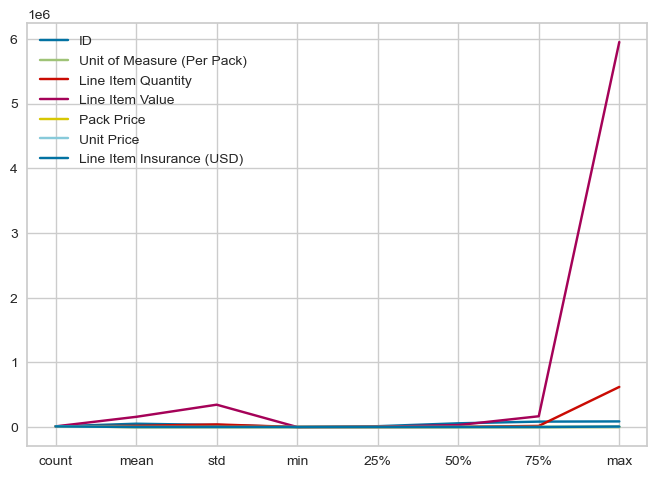

In [8]:
df.describe().plot.line()

In [9]:
df.describe()

,ID,Unit of Measure (Per Pack),Line Item Quantity,Line Item Value,Pack Price,Unit Price,Line Item Insurance (USD)
count,10324.000000,10324.000000,10324.000000,1.032400e+04,10324.000000,10324.000000,10037.000000
mean,51098.968229,77.990895,18332.534870,1.576506e+05,21.910241,0.611701,240.117626
std,31944.332496,76.579764,40035.302961,3.452921e+05,45.609223,3.275808,500.190568
min,1.000000,1.000000,1.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,12795.750000,30.000000,408.000000,4.314593e+03,4.120000,0.080000,6.510000
50%,57540.500000,60.000000,3000.000000,3.047147e+04,9.300000,0.160000,47.040000
75%,83648.250000,90.000000,17039.750000,1.664471e+05,23.592500,0.470000,252.400000
max,86823.000000,1000.000000,619999.000000,5.951990e+06,1345.640000,238.650000,7708.440000


In [10]:
df.shape

(10324, 33)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10324 entries, 0 to 10323
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID                            10324 non-null  int64  
 1   Project Code                  10324 non-null  object 
 2   PQ #                          10324 non-null  object 
 3   PO / SO #                     10324 non-null  object 
 4   ASN/DN #                      10324 non-null  object 
 5   Country                       10324 non-null  object 
 6   Managed By                    10324 non-null  object 
 7   Fulfill Via                   10324 non-null  object 
 8   Vendor INCO Term              10324 non-null  object 
 9   Shipment Mode                 9964 non-null   object 
 10  PQ First Sent to Client Date  10324 non-null  object 
 11  PO Sent to Vendor Date        10324 non-null  object 
 12  Scheduled Delivery Date       10324 non-null  object 
 13  D

In [12]:
df.nunique()

ID                              10324
Project Code                      142
PQ #                             1237
PO / SO #                        6233
ASN/DN #                         7030
Country                            43
Managed By                          4
Fulfill Via                         2
Vendor INCO Term                    8
Shipment Mode                       4
PQ First Sent to Client Date      765
PO Sent to Vendor Date            897
Scheduled Delivery Date          2006
Delivered to Client Date         2093
Delivery Recorded Date           2042
Product Group                       5
Sub Classification                  6
Vendor                             73
Item Description                  184
Molecule/Test Type                 86
Brand                              48
Dosage                             54
Dosage Form                        17
Unit of Measure (Per Pack)         31
Line Item Quantity               5065
Line Item Value                  8741
Pack Price  

In [13]:
df.isna().sum()

ID                                 0
Project Code                       0
PQ #                               0
PO / SO #                          0
ASN/DN #                           0
Country                            0
Managed By                         0
Fulfill Via                        0
Vendor INCO Term                   0
Shipment Mode                    360
PQ First Sent to Client Date       0
PO Sent to Vendor Date             0
Scheduled Delivery Date            0
Delivered to Client Date           0
Delivery Recorded Date             0
Product Group                      0
Sub Classification                 0
Vendor                             0
Item Description                   0
Molecule/Test Type                 0
Brand                              0
Dosage                          1736
Dosage Form                        0
Unit of Measure (Per Pack)         0
Line Item Quantity                 0
Line Item Value                    0
Pack Price                         0
U

### `Handling Null values`

In [14]:
def null_values(df, feature):
    match feature:
        case 'Line Item Insurance (USD)':
            df[feature] = df[feature].fillna(df['Line Item Insurance (USD)'].median())
            return df
        case 'Shipment Mode':
            df[feature]=df[feature].fillna("Other")
            return df
        case _:
            print('Error')

In [15]:
null_values(df, 'Line Item Insurance (USD)')
null_values(df, 'Shipment Mode')

,ID,Project Code,PQ #,PO / SO #,ASN/DN #,Country,Managed By,Fulfill Via,Vendor INCO Term,Shipment Mode,PQ First Sent to Client Date,PO Sent to Vendor Date,Scheduled Delivery Date,Delivered to Client Date,Delivery Recorded Date,Product Group,Sub Classification,Vendor,Item Description,Molecule/Test Type,Brand,Dosage,Dosage Form,Unit of Measure (Per Pack),Line Item Quantity,Line Item Value,Pack Price,Unit Price,Manufacturing Site,First Line Designation,Weight (Kilograms),Freight Cost (USD),Line Item Insurance (USD)
0,1,100-CI-T01,Pre-PQ Process,SCMS-4,ASN-8,Côte d'Ivoire,PMO - US,Direct Drop,EXW,Air,Pre-PQ Process,Date Not Captured,2-Jun-06,2-Jun-06,2-Jun-06,HRDT,HIV test,RANBAXY Fine Chemicals LTD.,"HIV, Reveal G3 Rapid HIV-1 Antibody Test, 30 T...","HIV, Reveal G3 Rapid HIV-1 Antibody Test",Reveal,NaN,Test kit,30,19,551.00,29.00,0.97,Ranbaxy Fine Chemicals LTD,Yes,13,780.34,47.04
1,3,108-VN-T01,Pre-PQ Process,SCMS-13,ASN-85,Vietnam,PMO - US,Direct Drop,EXW,Air,Pre-PQ Process,Date Not Captured,14-Nov-06,14-Nov-06,14-Nov-06,ARV,Pediatric,Aurobindo Pharma Limited,"Nevirapine 10mg/ml, oral suspension, Bottle, 2...",Nevirapine,Generic,10mg/ml,Oral suspension,240,1000,6200.00,6.20,0.03,"Aurobindo Unit III, India",Yes,358,4521.5,47.04
2,4,100-CI-T01,Pre-PQ Process,SCMS-20,ASN-14,Côte d'Ivoire,PMO - US,Direct Drop,FCA,Air,Pre-PQ Process,Date Not Captured,27-Aug-06,27-Aug-06,27-Aug-06,HRDT,HIV test,Abbott GmbH & Co. KG,"HIV 1/2, Determine Complete HIV Kit, 100 Tests","HIV 1/2, Determine Complete HIV Kit",Determine,NaN,Test kit,100,500,40000.00,80.00,0.80,ABBVIE GmbH & Co.KG Wiesbaden,Yes,171,1653.78,47.04
3,15,108-VN-T01,Pre-PQ Process,SCMS-78,ASN-50,Vietnam,PMO - US,Direct Drop,EXW,Air,Pre-PQ Process,Date Not Captured,1-Sep-06,1-Sep-06,1-Sep-06,ARV,Adult,SUN PHARMACEUTICAL INDUSTRIES LTD (RANBAXY LAB...,"Lamivudine 150mg, tablets, 60 Tabs",Lamivudine,Generic,150mg,Tablet,60,31920,127360.80,3.99,0.07,"Ranbaxy, Paonta Shahib, India",Yes,1855,16007.06,47.04
4,16,108-VN-T01,Pre-PQ Process,SCMS-81,ASN-55,Vietnam,PMO - US,Direct Drop,EXW,Air,Pre-PQ Process,Date Not Captured,11-Aug-06,11-Aug-06,11-Aug-06,ARV,Adult,Aurobindo Pharma Limited,"Stavudine 30mg, capsules, 60 Caps",Stavudine,Generic,30mg,Capsule,60,38000,121600.00,3.20,0.05,"Aurobindo Unit III, India",Yes,7590,45450.08,47.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10319,86818,103-ZW-T30,FPQ-15197,SO-50020,DN-4307,Zimbabwe,PMO - US,From RDC,N/A - From RDC,Truck,10/16/14,N/A - From RDC,31-Jul-15,15-Jul-15,20-Jul-15,ARV,Pediatric,SCMS from RDC,"Lamivudine/Nevirapine/Zidovudine 30/50/60mg, d...",Lamivudine/Nevirapine/Zidovudine,Generic,30/50/60mg,Chewable/dispersible tablet - FDC,60,166571,599655.60,3.60,0.06,"Mylan, H-12 & H-13, India",No,See DN-4307 (ID#:83920),See DN-4307 (ID#:83920),705.79
10320,86819,104-CI-T30,FPQ-15259,SO-50102,DN-4313,Côte d'Ivoire,PMO - US,From RDC,N/A - From RDC,Truck,10/24/14,N/A - From RDC,31-Jul-15,6-Aug-15,7-Aug-15,ARV,Adult,SCMS from RDC,"Lamivudine/Zidovudine 150/300mg, tablets, 60 Tabs",Lamivudine/Zidovudine,Generic,150/300mg,Tablet - FDC,60,21072,137389.44,6.52,0.11,Hetero Unit III Hyderabad IN,No,See DN-4313 (ID#:83921),See DN-4313 (ID#:83921),161.71
10321,86821,110-ZM-T30,FPQ-14784,SO-49600,DN-4316,Zambia,PMO - US,From RDC,N/A - From RDC,Truck,8/12/14,N/A - From RDC,31-Aug-15,25-Aug-15,3-Sep-15,ARV,Adult,SCMS from RDC,Efavirenz/Lamivudine/Tenofovir Disoproxil Fuma...,Efavirenz/Lamivudine/Tenofovir Disoproxil Fuma...,Generic,600/300/300mg,Tablet - FDC,30,514526,5140114.74,9.99,0.33,Cipla Ltd A-42 MIDC Mahar. IN,No,Weight Captured Separately,Freight Included in Commodity Cost,5284.04
10322,86822,200-ZW-T30,FPQ-16523,SO-51680,DN-4334,Zimbabwe,PMO - US,From RDC,N/A - From RDC,Truck,7/1/15,N/A - From RDC,9-Sep-15,4-Aug-15,11-Aug-15,ARV,Adult,SCMS from RDC,"Lamivudine/Zidovudine 150/300mg, tablets, 60 Tabs",Lamivudine/Zidovudine,Generic,150/300mg,Tablet - FDC,60,

In [16]:
df.isna().sum()

ID                                 0
Project Code                       0
PQ #                               0
PO / SO #                          0
ASN/DN #                           0
Country                            0
Managed By                         0
Fulfill Via                        0
Vendor INCO Term                   0
Shipment Mode                      0
PQ First Sent to Client Date       0
PO Sent to Vendor Date             0
Scheduled Delivery Date            0
Delivered to Client Date           0
Delivery Recorded Date             0
Product Group                      0
Sub Classification                 0
Vendor                             0
Item Description                   0
Molecule/Test Type                 0
Brand                              0
Dosage                          1736
Dosage Form                        0
Unit of Measure (Per Pack)         0
Line Item Quantity                 0
Line Item Value                    0
Pack Price                         0
U

### `Data Cleaning part_1`

In [17]:
def replace_strings(df, feature):
    match feature:
        case 'Freight Cost (USD)':
            df[feature]=df[feature].replace("Freight Included in Commodity Cost",0)
            df.loc[df[feature].str.contains('See', na=False), feature] = 'test'
            df[feature] = df[feature].replace('test', 0)
            return df
        case 'Weight (Kilograms)':
            df[feature] = df[feature].replace('Weight Captured Separately', 0)
            df.loc[df[feature].str.contains('See', na=False), feature] = 'test'
            df[feature] = df[feature].replace('test', 0)
            return df
        case 'PO / SO #':
            df.loc[df[feature].str.contains('SCMS', na=False), feature] = 'SCMS'
            df.loc[df[feature].str.contains('SO', na=False), feature] = 'SO'
            return df
        case 'ASN/DN #':
            df.loc[df[feature].str.contains('ASN', na=False), feature] = 'ASN'
            df.loc[df[feature].str.contains('DN', na=False), feature] = 'DN'
        case _:
            print('Error')

In [18]:
replace_strings(df, 'Freight Cost (USD)')
replace_strings(df, 'Weight (Kilograms)')
replace_strings(df, 'PO / SO #')
replace_strings(df, 'ASN/DN #')

In [19]:
df.nunique()

ID                              10324
Project Code                      142
PQ #                             1237
PO / SO #                           3
ASN/DN #                            2
Country                            43
Managed By                          4
Fulfill Via                         2
Vendor INCO Term                    8
Shipment Mode                       5
PQ First Sent to Client Date      765
PO Sent to Vendor Date            897
Scheduled Delivery Date          2006
Delivered to Client Date         2093
Delivery Recorded Date           2042
Product Group                       5
Sub Classification                  6
Vendor                             73
Item Description                  184
Molecule/Test Type                 86
Brand                              48
Dosage                             54
Dosage Form                        17
Unit of Measure (Per Pack)         31
Line Item Quantity               5065
Line Item Value                  8741
Pack Price  

In [20]:
df['PO / SO #'].value_counts()

SO            5404
SCMS          4919
DSCM-10090       1
Name: PO / SO #, dtype: int64

In [21]:
df = df[df["PO / SO #"] != 'DSCM-10090']

In [22]:
df=df[(df["Freight Cost (USD)"]!='Invoiced Separately')]

In [23]:
df.shape

(10084, 33)

In [24]:
df['Freight Cost (USD)'].value_counts()

0           3887
9736.1        36
6147.18       27
7445.8        16
13398.06      16
            ... 
36096.76       1
52057.8        1
4312.92        1
25129.15       1
3410           1
Name: Freight Cost (USD), Length: 5432, dtype: int64

In [25]:
df['Freight Cost (USD)'] = df['Freight Cost (USD)'].astype('float')

In [26]:
df['Weight (Kilograms)'] = df['Weight (Kilograms)'].astype('float')

In [27]:
df

,ID,Project Code,PQ #,PO / SO #,ASN/DN #,Country,Managed By,Fulfill Via,Vendor INCO Term,Shipment Mode,PQ First Sent to Client Date,PO Sent to Vendor Date,Scheduled Delivery Date,Delivered to Client Date,Delivery Recorded Date,Product Group,Sub Classification,Vendor,Item Description,Molecule/Test Type,Brand,Dosage,Dosage Form,Unit of Measure (Per Pack),Line Item Quantity,Line Item Value,Pack Price,Unit Price,Manufacturing Site,First Line Designation,Weight (Kilograms),Freight Cost (USD),Line Item Insurance (USD)
0,1,100-CI-T01,Pre-PQ Process,SCMS,ASN,Côte d'Ivoire,PMO - US,Direct Drop,EXW,Air,Pre-PQ Process,Date Not Captured,2-Jun-06,2-Jun-06,2-Jun-06,HRDT,HIV test,RANBAXY Fine Chemicals LTD.,"HIV, Reveal G3 Rapid HIV-1 Antibody Test, 30 T...","HIV, Reveal G3 Rapid HIV-1 Antibody Test",Reveal,NaN,Test kit,30,19,551.00,29.00,0.97,Ranbaxy Fine Chemicals LTD,Yes,13.0,780.34,47.04
1,3,108-VN-T01,Pre-PQ Process,SCMS,ASN,Vietnam,PMO - US,Direct Drop,EXW,Air,Pre-PQ Process,Date Not Captured,14-Nov-06,14-Nov-06,14-Nov-06,ARV,Pediatric,Aurobindo Pharma Limited,"Nevirapine 10mg/ml, oral suspension, Bottle, 2...",Nevirapine,Generic,10mg/ml,Oral suspension,240,1000,6200.00,6.20,0.03,"Aurobindo Unit III, India",Yes,358.0,4521.50,47.04
2,4,100-CI-T01,Pre-PQ Process,SCMS,ASN,Côte d'Ivoire,PMO - US,Direct Drop,FCA,Air,Pre-PQ Process,Date Not Captured,27-Aug-06,27-Aug-06,27-Aug-06,HRDT,HIV test,Abbott GmbH & Co. KG,"HIV 1/2, Determine Complete HIV Kit, 100 Tests","HIV 1/2, Determine Complete HIV Kit",Determine,NaN,Test kit,100,500,40000.00,80.00,0.80,ABBVIE GmbH & Co.KG Wiesbaden,Yes,171.0,1653.78,47.04
3,15,108-VN-T01,Pre-PQ Process,SCMS,ASN,Vietnam,PMO - US,Direct Drop,EXW,Air,Pre-PQ Process,Date Not Captured,1-Sep-06,1-Sep-06,1-Sep-06,ARV,Adult,SUN PHARMACEUTICAL INDUSTRIES LTD (RANBAXY LAB...,"Lamivudine 150mg, tablets, 60 Tabs",Lamivudine,Generic,150mg,Tablet,60,31920,127360.80,3.99,0.07,"Ranbaxy, Paonta Shahib, India",Yes,1855.0,16007.06,47.04
4,16,108-VN-T01,Pre-PQ Process,SCMS,ASN,Vietnam,PMO - US,Direct Drop,EXW,Air,Pre-PQ Process,Date Not Captured,11-Aug-06,11-Aug-06,11-Aug-06,ARV,Adult,Aurobindo Pharma Limited,"Stavudine 30mg, capsules, 60 Caps",Stavudine,Generic,30mg,Capsule,60,38000,121600.00,3.20,0.05,"Aurobindo Unit III, India",Yes,7590.0,45450.08,47.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10319,86818,103-ZW-T30,FPQ-15197,SO,DN,Zimbabwe,PMO - US,From RDC,N/A - From RDC,Truck,10/16/14,N/A - From RDC,31-Jul-15,15-Jul-15,20-Jul-15,ARV,Pediatric,SCMS from RDC,"Lamivudine/Nevirapine/Zidovudine 30/50/60mg, d...",Lamivudine/Nevirapine/Zidovudine,Generic,30/50/60mg,Chewable/dispersible tablet - FDC,60,166571,599655.60,3.60,0.06,"Mylan, H-12 & H-13, India",No,0.0,0.00,705.79
10320,86819,104-CI-T30,FPQ-15259,SO,DN,Côte d'Ivoire,PMO - US,From RDC,N/A - From RDC,Truck,10/24/14,N/A - From RDC,31-Jul-15,6-Aug-15,7-Aug-15,ARV,Adult,SCMS from RDC,"Lamivudine/Zidovudine 150/300mg, tablets, 60 Tabs",Lamivudine/Zidovudine,Generic,150/300mg,Tablet - FDC,60,21072,137389.44,6.52,0.11,Hetero Unit III Hyderabad IN,No,0.0,0.00,161.71
10321,86821,110-ZM-T30,FPQ-14784,SO,DN,Zambia,PMO - US,From RDC,N/A - From RDC,Truck,8/12/14,N/A - From RDC,31-Aug-15,25-Aug-15,3-Sep-15,ARV,Adult,SCMS from RDC,Efavirenz/Lamivudine/Tenofovir Disoproxil Fuma...,Efavirenz/Lamivudine/Tenofovir Disoproxil Fuma...,Generic,600/300/300mg,Tablet - FDC,30,514526,5140114.74,9.99,0.33,Cipla Ltd A-42 MIDC Mahar. IN,No,0.0,0.00,5284.04
10322,86822,200-ZW-T30,FPQ-16523,SO,DN,Zimbabwe,PMO - US,From RDC,N/A - From RDC,Truck,7/1/15,N/A - From RDC,9-Sep-15,4-Aug-15,11-Aug-15,ARV,Adult,SCMS from RDC,"Lamivudine/Zidovudine 150/300mg, tablets, 60 Tabs",Lamivudine/Zidovudine,Generic,150/300mg,Tablet - FDC,60,17465,113871.80,6.52,0.11,Mylan (formerly Matrix) Nashik,Yes,1392.0,0.00,134.03


In [28]:
df['Sub Classification'].unique()

array(['HIV test', 'Pediatric', 'Adult', 'HIV test - Ancillary', 'ACT',
       'Malaria'], dtype=object)

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10084 entries, 0 to 10323
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID                            10084 non-null  int64  
 1   Project Code                  10084 non-null  object 
 2   PQ #                          10084 non-null  object 
 3   PO / SO #                     10084 non-null  object 
 4   ASN/DN #                      10084 non-null  object 
 5   Country                       10084 non-null  object 
 6   Managed By                    10084 non-null  object 
 7   Fulfill Via                   10084 non-null  object 
 8   Vendor INCO Term              10084 non-null  object 
 9   Shipment Mode                 10084 non-null  object 
 10  PQ First Sent to Client Date  10084 non-null  object 
 11  PO Sent to Vendor Date        10084 non-null  object 
 12  Scheduled Delivery Date       10084 non-null  object 
 13  D

# `EDA`

In [30]:
df['Shipment Mode'].value_counts(normalize=True) * 100

Air            58.726696
Truck          27.746926
Air Charter     6.426021
Other           3.570012
Ocean           3.530345
Name: Shipment Mode, dtype: float64

In [31]:
def value_count_norm(df, feature):
    value_count = df[feature].value_counts()
    value_count_norm_1 = df[feature].value_counts(normalize=True) * 100
    value_count_norm_1_concat = pd.concat([value_count, value_count_norm_1], axis=1)
    value_count_norm_1_concat.columns = ['Count', 'Frequency %']
    return value_count_norm_1_concat

In [32]:
def create_bar_plot(df, feature):
    sns.barplot(x=value_count_norm(df, feature).index, y=value_count_norm(df, feature).iloc[:, 0])
    plt.title('{}'.format(feature))
    return plt.show()

In [33]:
def create_hist_plot(df, feature):
    sns.histplot(df[feature])
    plt.title('{}'.format(feature))
    return plt.show()

In [34]:
len(value_count_norm(df, 'Fulfill Via').index)

2

In [35]:
def create_pie_chart(df, feature):
    n = len(value_count_norm(df, feature).index)
    colors = sns.color_palette('pastel')[0:n]
    plt.pie(value_count_norm(df, feature).iloc[:, 1],
            colors = colors, autopct='%1.2f%%', 
            labels=value_count_norm(df, feature).index)
    plt.title('{}'.format(feature))
    return plt.show()

In [36]:
def get_info(df, feature):
    match feature:
        case 'Line Item Insurance (USD)' | 'Freight Cost (USD)' | 'Consiment_price' | 'Weight (Kilograms)' | 'Line Item Quantity':
            print('Description:\n{}'.format((np.abs(df[feature])).describe()))
            print('*'*50)
            print('Object type:{}'.format(df[feature].dtype))
        case 'Shipment Mode' | 'Fulfill Via' | 'First Line Designation' | 'Vendor INCO Term' | 'Sub Classification' | 'Managed By' | 'PO / SO #' | 'ASN/DN #':
            #print('Description:\n{}'.format(df([feature]).describe())
            print('Description:\n{}'.format(df[feature].describe()))
            print('*'*50)
            print('Object type:\n{}'.format(df[feature].dtype))
            print('*'*50)
            print('Value count:\n{}'.format(value_count_norm(df, feature)))
        case _:
            print('Error')

In [37]:
def get_report(df, feature):
    match feature:
        case 'Fulfill Via' | 'First Line Designation' | 'PO / SO #' | 'ASN/DN #':
            get_info(df, feature)
            print('*'*50)
            create_pie_chart(df, feature)
        case 'Shipment Mode' | 'Vendor INCO Term' | 'Sub Classification' | 'Managed By' | 'Dosage Form':
            get_info(df, feature)
            print('*'*50)
            create_bar_plot(df, feature)
        case 'Line Item Insurance (USD)' | 'Freight Cost (USD)' | 'Consiment_price' | 'Weight (Kilograms)' | 'Line Item Quantity' :
            get_info(df, feature)
            print('*'*50)
            create_hist_plot(df, feature)
        case _:
            print("Error")
            

Description:
count        10084
unique           2
top       From RDC
freq          5328
Name: Fulfill Via, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
             Count  Frequency %
From RDC      5328    52.836176
Direct Drop   4756    47.163824
**************************************************


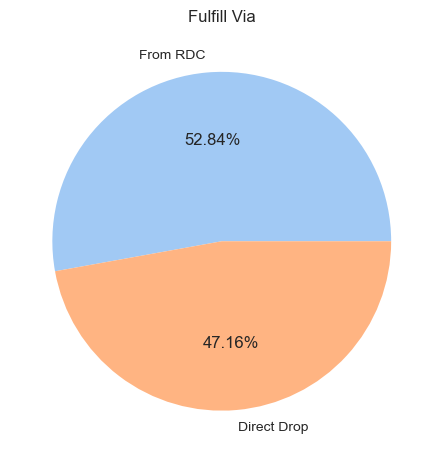

In [38]:
get_report(df, 'Fulfill Via')

Description:
count     10084
unique        2
top          DN
freq       5328
Name: ASN/DN #, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
     Count  Frequency %
DN    5328    52.836176
ASN   4756    47.163824
**************************************************


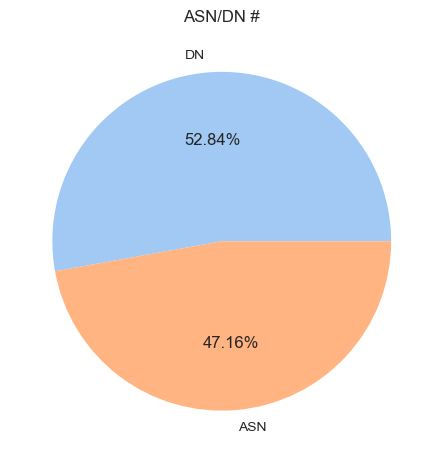

In [39]:
get_report(df, 'ASN/DN #')

Description:
count        10084
unique           4
top       PMO - US
freq         10025
Name: Managed By, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                           Count  Frequency %
PMO - US                   10025    99.414915
South Africa Field Office     57     0.565252
Haiti Field Office             1     0.009917
Ethiopia Field Office          1     0.009917
**************************************************


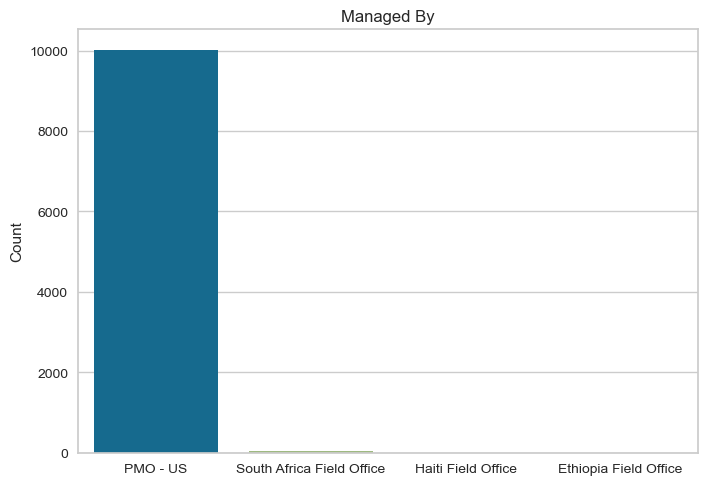

In [40]:
get_report(df, 'Managed By')

Description:
count     10084
unique        2
top         Yes
freq       6790
Name: First Line Designation, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
     Count  Frequency %
Yes   6790    67.334391
No    3294    32.665609
**************************************************


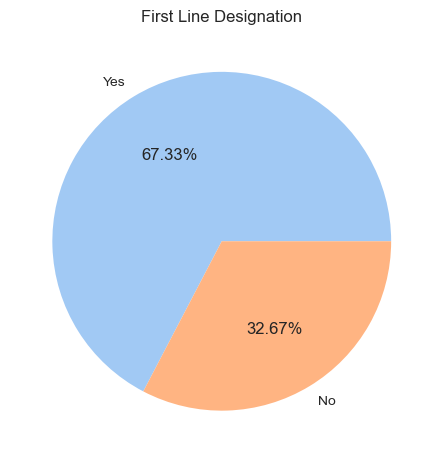

In [41]:
get_report(df, 'First Line Designation')

Description:
count     10084
unique        2
top          SO
freq       5328
Name: PO / SO #, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
      Count  Frequency %
SO     5328    52.836176
SCMS   4756    47.163824
**************************************************


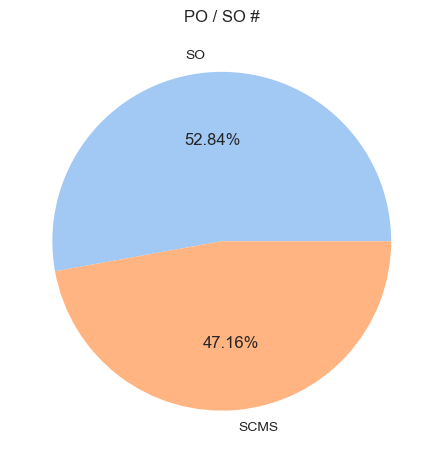

In [42]:
get_report(df, 'PO / SO #')

Description:
count              10084
unique                 8
top       N/A - From RDC
freq                5328
Name: Vendor INCO Term, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                Count  Frequency %
N/A - From RDC   5328    52.836176
EXW              2639    26.170171
DDP              1443    14.309798
FCA               372     3.689012
CIP               275     2.727092
DDU                15     0.148750
DAP                 9     0.089250
CIF                 3     0.029750
**************************************************


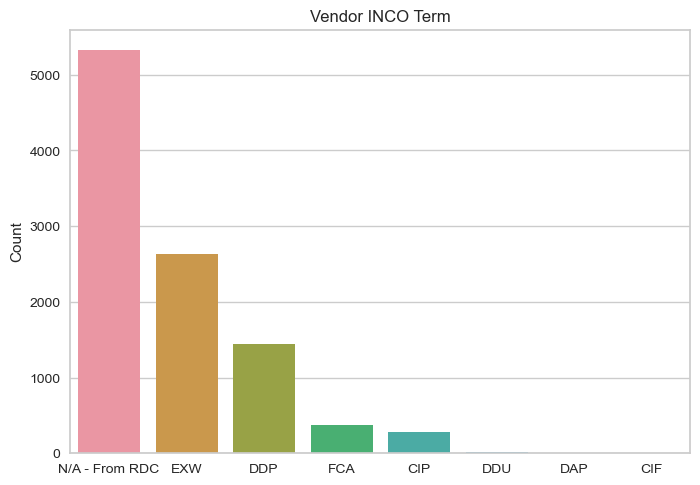

In [43]:
get_report(df, 'Vendor INCO Term')

Description:
count     10084
unique        6
top       Adult
freq       6486
Name: Sub Classification, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                      Count  Frequency %
Adult                  6486    64.319714
Pediatric              1914    18.980563
HIV test               1510    14.974217
HIV test - Ancillary    129     1.279254
Malaria                  29     0.287584
ACT                      16     0.158667
**************************************************


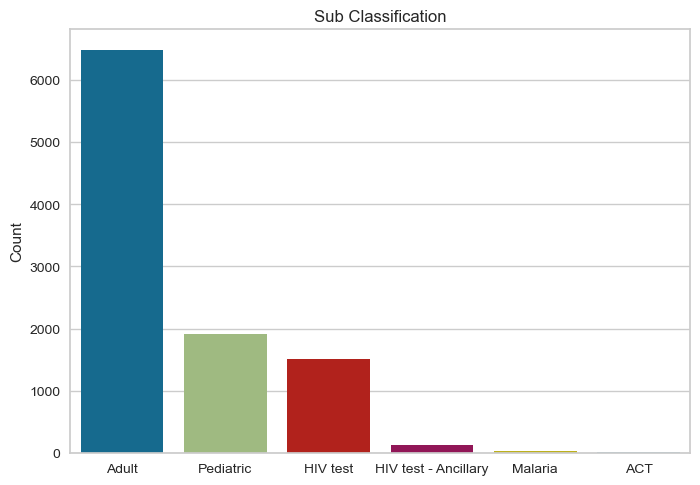

In [44]:
get_report(df, 'Sub Classification')

Description:
count     10084
unique        5
top         Air
freq       5922
Name: Shipment Mode, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
             Count  Frequency %
Air           5922    58.726696
Truck         2798    27.746926
Air Charter    648     6.426021
Other          360     3.570012
Ocean          356     3.530345
**************************************************


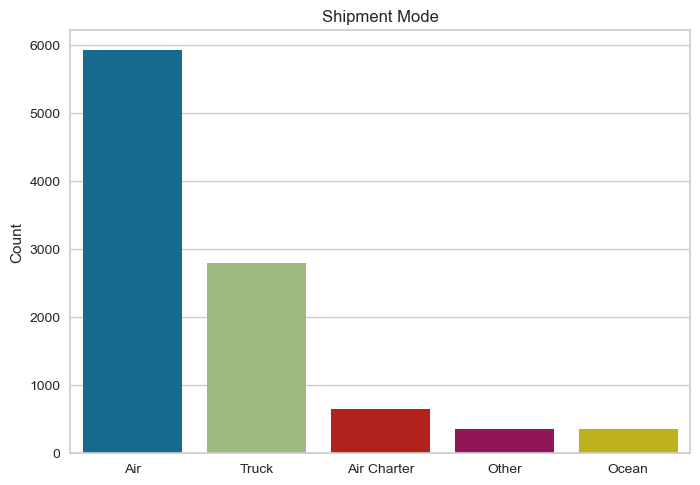

In [45]:
get_report(df, 'Shipment Mode')

Error
**************************************************


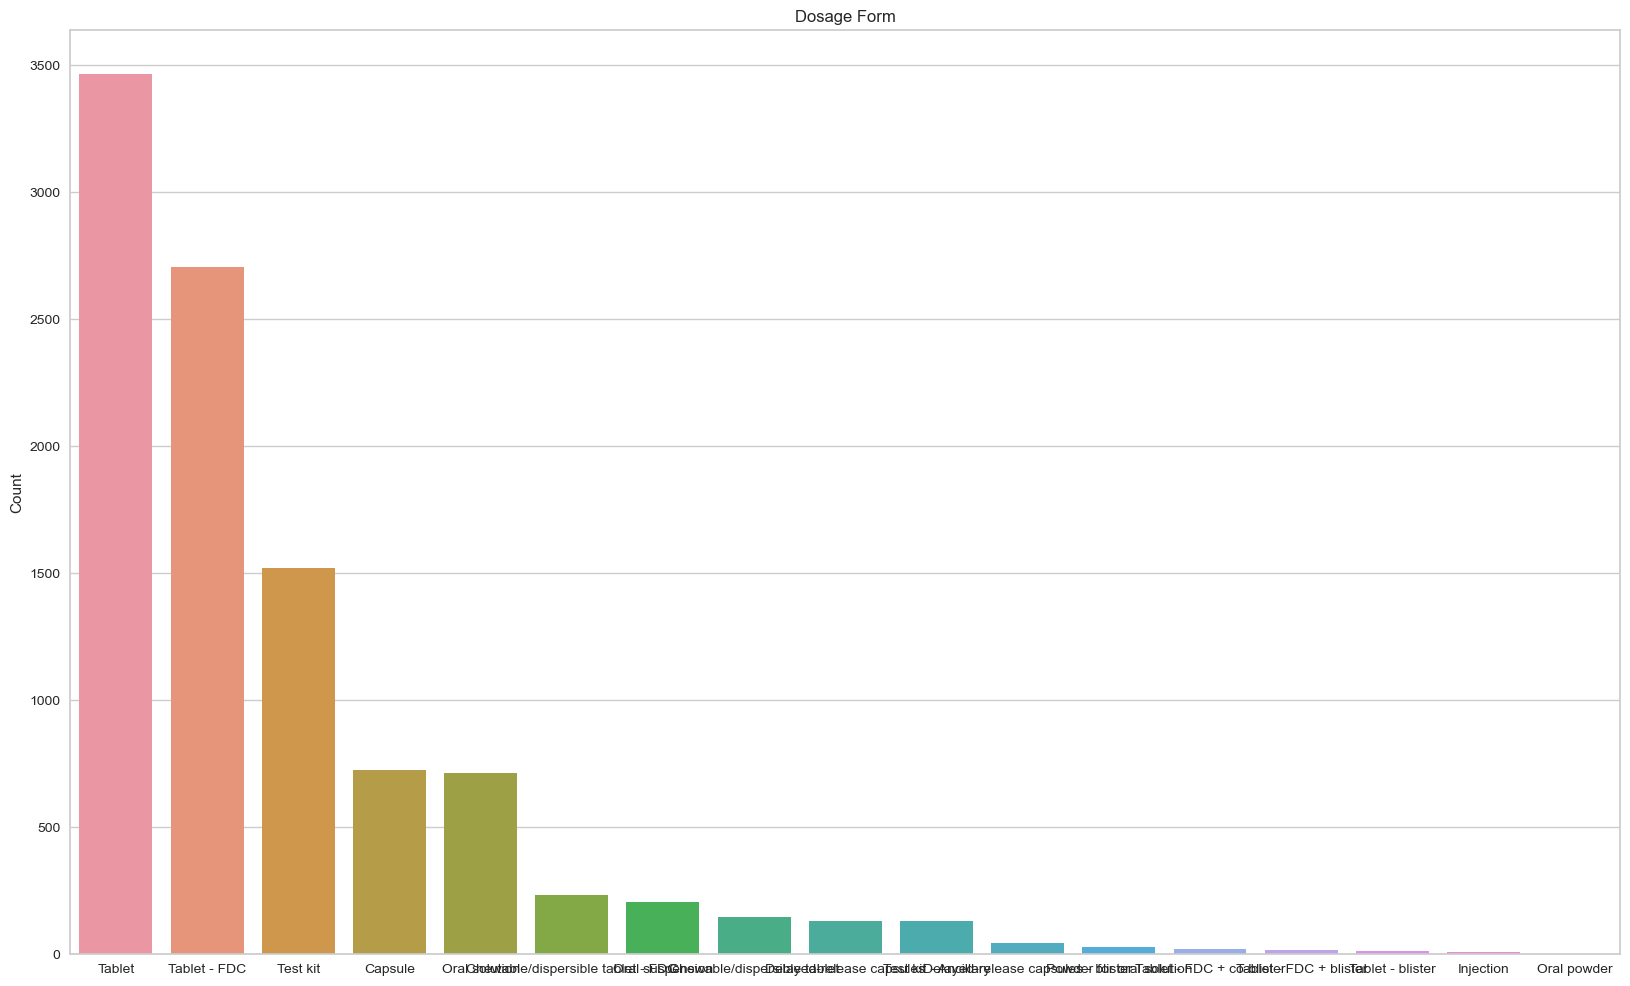

In [46]:
figure(figsize=(20, 12))
get_report(df, 'Dosage Form')

Description:
count     10084.000000
mean       2162.121380
std       10877.957251
min           0.000000
25%           0.000000
50%         146.000000
75%        1671.000000
max      857354.000000
Name: Weight (Kilograms), dtype: float64
**************************************************
Object type:float64
**************************************************
ERROR! Session/line number was not unique in database. History logging moved to new session 379


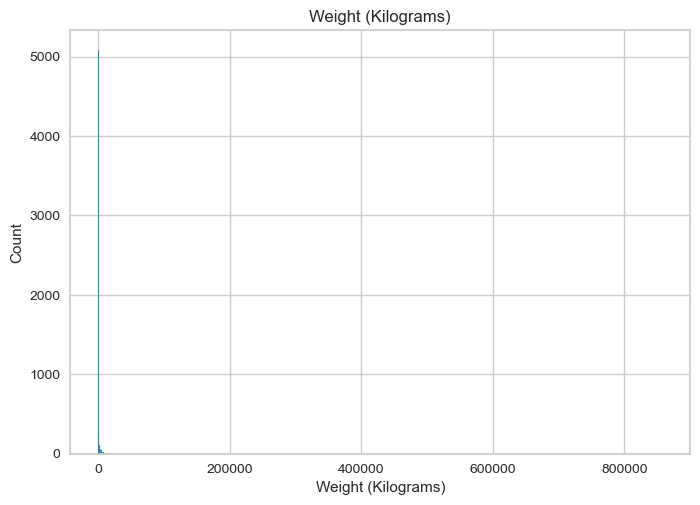

In [48]:
get_report(df, 'Weight (Kilograms)')

Description:
count     10084.000000
mean       6822.375411
std       13522.921939
min           0.000000
25%           0.000000
50%        1583.545000
75%        7962.252500
max      289653.200000
Name: Freight Cost (USD), dtype: float64
**************************************************
Object type:float64
**************************************************


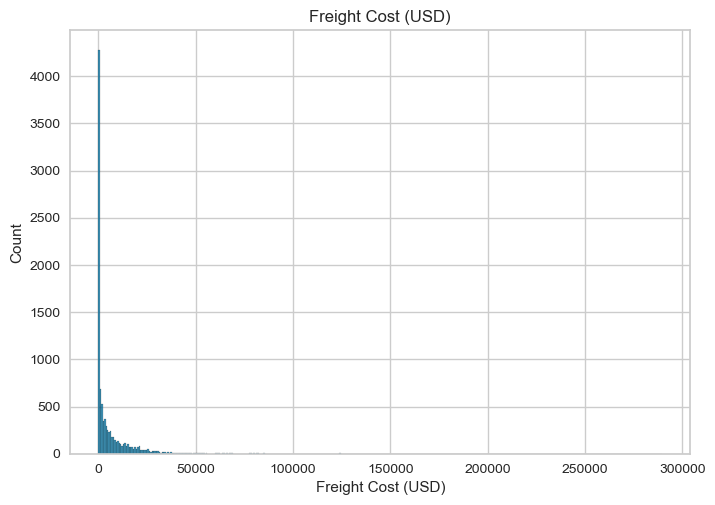

In [49]:
get_report(df, 'Freight Cost (USD)')

sns.regplot(x='Consiment_price', y='Line Item Insurance (USD)', data=df, line_kws={'color':'red'},scatter_kws={'alpha':0.5})

In [50]:
df['Vendor INCO Term'].value_counts()

N/A - From RDC    5328
EXW               2639
DDP               1443
FCA                372
CIP                275
DDU                 15
DAP                  9
CIF                  3
Name: Vendor INCO Term, dtype: int64

<AxesSubplot:>

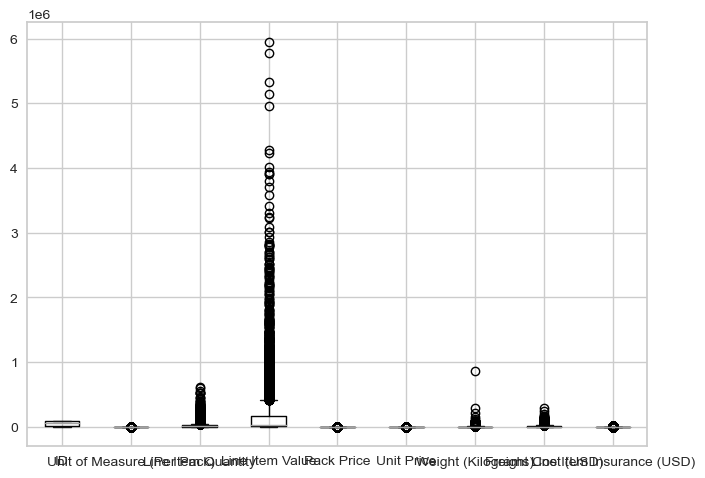

In [51]:
df.boxplot()

In [52]:
df.columns

Index(['ID', 'Project Code', 'PQ #', 'PO / SO #', 'ASN/DN #', 'Country',
       'Managed By', 'Fulfill Via', 'Vendor INCO Term', 'Shipment Mode',
       'PQ First Sent to Client Date', 'PO Sent to Vendor Date',
       'Scheduled Delivery Date', 'Delivered to Client Date',
       'Delivery Recorded Date', 'Product Group', 'Sub Classification',
       'Vendor', 'Item Description', 'Molecule/Test Type', 'Brand', 'Dosage',
       'Dosage Form', 'Unit of Measure (Per Pack)', 'Line Item Quantity',
       'Line Item Value', 'Pack Price', 'Unit Price', 'Manufacturing Site',
       'First Line Designation', 'Weight (Kilograms)', 'Freight Cost (USD)',
       'Line Item Insurance (USD)'],
      dtype='object')

## `Data Cleaning`

In [53]:
def outlier_thresholds_iqr(df, feature, th1, th3):
    Q1 = df[feature].quantile(th1)
    Q3 = df[feature].quantile(th3)
    IQR = Q3 - Q1
    upper_limit = Q3 + 3 * IQR
    lower_limit = Q1 - 1 * IQR
    return upper_limit, lower_limit

In [54]:
columns_list = ['Unit of Measure (Per Pack)',  'Line Item Value', 'Unit Price', 'Pack Price', 'Weight (Kilograms)', 'Freight Cost (USD)']
for i in columns_list:
    if i != 'Outcome':
        print('################################')
        print(i, ":", outlier_thresholds_iqr(df, i, th1=0.25, th3=0.75))
    else:
        pass

################################
Unit of Measure (Per Pack) : (270.0, -30.0)
################################
Line Item Value : (660025.75, -159430.5)
################################
Unit Price : (1.6, -0.3)
################################
Pack Price : (81.32000000000002, -15.142500000000004)
################################
Weight (Kilograms) : (6684.0, -1671.0)
################################
Freight Cost (USD) : (31849.010000000002, -7962.2525000000005)


In [55]:
def check_outliers_iqr(df, feature):
    upper_limit, lower_limit = outlier_thresholds_iqr(df, feature, th1=0.25, th3=0.75)
    if df[(df[feature] > upper_limit) | (df[feature] < lower_limit)].any(axis=None):
        return True
    else:
        return False

In [56]:
from tabulate import tabulate
def replace_with_thresholds_iqr(df, features, th1=0.25, th3=0.75, replace=True):
    data = []
    for feature in features:
        if feature != 'Outcome':
            outliers = check_outliers_iqr(df, feature)
            count = None
            upper_limit, lower_limit = outlier_thresholds_iqr(df, feature, th1=0.25, th3=0.75)
            if outliers:
                count = df[(df[feature] > upper_limit) | (df[feature] < lower_limit)][feature].count()
                if replace:
                    if lower_limit < 0:
                        df.loc[(df[feature] > upper_limit), feature] = upper_limit
                    else:
                        df.loc[(df[feature] < lower_limit), feature] = lower_limit
                        df.loc[(df[feature] > upper_limit), feature] = upper_limit
            outliers_status = check_outliers_iqr(df, feature)
            data.append([outliers, outliers_status, count, feature, upper_limit, lower_limit ])
    table = tabulate(data, headers=['Unit of Measure (Per Pack)',  'Line Item Value', 'Unit Price', 'Pack Price', 'Weight (Kilograms)', 'Freight Cost (USD)', 'Line Item Insurance (USD)'], tablefmt='rst', numalign='right')
    print(table)


replace_with_thresholds_iqr(df, columns_list, th1=0.25, th3=0.75)

============================  =================  ============  ==========================  ====================  ====================
Unit of Measure (Per Pack)    Line Item Value      Unit Price  Pack Price                    Weight (Kilograms)    Freight Cost (USD)
============================  =================  ============  ==========================  ====================  ====================
True                          False                       214  Unit of Measure (Per Pack)                   270                   -30
True                          False                       565  Line Item Value                           660026               -159430
True                          False                       271  Unit Price                                   1.6                  -0.3
True                          False                       430  Pack Price                                 81.32              -15.1425
True                          False                       799 

In [57]:
df

,ID,Project Code,PQ #,PO / SO #,ASN/DN #,Country,Managed By,Fulfill Via,Vendor INCO Term,Shipment Mode,PQ First Sent to Client Date,PO Sent to Vendor Date,Scheduled Delivery Date,Delivered to Client Date,Delivery Recorded Date,Product Group,Sub Classification,Vendor,Item Description,Molecule/Test Type,Brand,Dosage,Dosage Form,Unit of Measure (Per Pack),Line Item Quantity,Line Item Value,Pack Price,Unit Price,Manufacturing Site,First Line Designation,Weight (Kilograms),Freight Cost (USD),Line Item Insurance (USD)
0,1,100-CI-T01,Pre-PQ Process,SCMS,ASN,Côte d'Ivoire,PMO - US,Direct Drop,EXW,Air,Pre-PQ Process,Date Not Captured,2-Jun-06,2-Jun-06,2-Jun-06,HRDT,HIV test,RANBAXY Fine Chemicals LTD.,"HIV, Reveal G3 Rapid HIV-1 Antibody Test, 30 T...","HIV, Reveal G3 Rapid HIV-1 Antibody Test",Reveal,NaN,Test kit,30,19,551.00,29.00,0.97,Ranbaxy Fine Chemicals LTD,Yes,13.0,780.34,47.04
1,3,108-VN-T01,Pre-PQ Process,SCMS,ASN,Vietnam,PMO - US,Direct Drop,EXW,Air,Pre-PQ Process,Date Not Captured,14-Nov-06,14-Nov-06,14-Nov-06,ARV,Pediatric,Aurobindo Pharma Limited,"Nevirapine 10mg/ml, oral suspension, Bottle, 2...",Nevirapine,Generic,10mg/ml,Oral suspension,240,1000,6200.00,6.20,0.03,"Aurobindo Unit III, India",Yes,358.0,4521.50,47.04
2,4,100-CI-T01,Pre-PQ Process,SCMS,ASN,Côte d'Ivoire,PMO - US,Direct Drop,FCA,Air,Pre-PQ Process,Date Not Captured,27-Aug-06,27-Aug-06,27-Aug-06,HRDT,HIV test,Abbott GmbH & Co. KG,"HIV 1/2, Determine Complete HIV Kit, 100 Tests","HIV 1/2, Determine Complete HIV Kit",Determine,NaN,Test kit,100,500,40000.00,80.00,0.80,ABBVIE GmbH & Co.KG Wiesbaden,Yes,171.0,1653.78,47.04
3,15,108-VN-T01,Pre-PQ Process,SCMS,ASN,Vietnam,PMO - US,Direct Drop,EXW,Air,Pre-PQ Process,Date Not Captured,1-Sep-06,1-Sep-06,1-Sep-06,ARV,Adult,SUN PHARMACEUTICAL INDUSTRIES LTD (RANBAXY LAB...,"Lamivudine 150mg, tablets, 60 Tabs",Lamivudine,Generic,150mg,Tablet,60,31920,127360.80,3.99,0.07,"Ranbaxy, Paonta Shahib, India",Yes,1855.0,16007.06,47.04
4,16,108-VN-T01,Pre-PQ Process,SCMS,ASN,Vietnam,PMO - US,Direct Drop,EXW,Air,Pre-PQ Process,Date Not Captured,11-Aug-06,11-Aug-06,11-Aug-06,ARV,Adult,Aurobindo Pharma Limited,"Stavudine 30mg, capsules, 60 Caps",Stavudine,Generic,30mg,Capsule,60,38000,121600.00,3.20,0.05,"Aurobindo Unit III, India",Yes,6684.0,31849.01,47.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10319,86818,103-ZW-T30,FPQ-15197,SO,DN,Zimbabwe,PMO - US,From RDC,N/A - From RDC,Truck,10/16/14,N/A - From RDC,31-Jul-15,15-Jul-15,20-Jul-15,ARV,Pediatric,SCMS from RDC,"Lamivudine/Nevirapine/Zidovudine 30/50/60mg, d...",Lamivudine/Nevirapine/Zidovudine,Generic,30/50/60mg,Chewable/dispersible tablet - FDC,60,166571,599655.60,3.60,0.06,"Mylan, H-12 & H-13, India",No,0.0,0.00,705.79
10320,86819,104-CI-T30,FPQ-15259,SO,DN,Côte d'Ivoire,PMO - US,From RDC,N/A - From RDC,Truck,10/24/14,N/A - From RDC,31-Jul-15,6-Aug-15,7-Aug-15,ARV,Adult,SCMS from RDC,"Lamivudine/Zidovudine 150/300mg, tablets, 60 Tabs",Lamivudine/Zidovudine,Generic,150/300mg,Tablet - FDC,60,21072,137389.44,6.52,0.11,Hetero Unit III Hyderabad IN,No,0.0,0.00,161.71
10321,86821,110-ZM-T30,FPQ-14784,SO,DN,Zambia,PMO - US,From RDC,N/A - From RDC,Truck,8/12/14,N/A - From RDC,31-Aug-15,25-Aug-15,3-Sep-15,ARV,Adult,SCMS from RDC,Efavirenz/Lamivudine/Tenofovir Disoproxil Fuma...,Efavirenz/Lamivudine/Tenofovir Disoproxil Fuma...,Generic,600/300/300mg,Tablet - FDC,30,514526,660025.75,9.99,0.33,Cipla Ltd A-42 MIDC Mahar. IN,No,0.0,0.00,5284.04
10322,86822,200-ZW-T30,FPQ-16523,SO,DN,Zimbabwe,PMO - US,From RDC,N/A - From RDC,Truck,7/1/15,N/A - From RDC,9-Sep-15,4-Aug-15,11-Aug-15,ARV,Adult,SCMS from RDC,"Lamivudine/Zidovudine 150/300mg, tablets, 60 Tabs",Lamivudine/Zidovudine,Generic,150/300mg,Tablet - FDC,60,17465,113871.80,6.52,0.11,Mylan (formerly Matrix) Nashik,Yes,1392.0,0.00,134.03


In [58]:
df['Scheduled Delivery Date'] = pd.to_datetime(df['Scheduled Delivery Date'])
df['Delivery Recorded Date'] = pd.to_datetime(df['Delivery Recorded Date'])

In [59]:
df['Delay'] = df['Delivery Recorded Date'] - df['Scheduled Delivery Date']

In [60]:
df['Delay'] = df['Delay'].dt.days.astype('int64')

In [61]:
df

,ID,Project Code,PQ #,PO / SO #,ASN/DN #,Country,Managed By,Fulfill Via,Vendor INCO Term,Shipment Mode,PQ First Sent to Client Date,PO Sent to Vendor Date,Scheduled Delivery Date,Delivered to Client Date,Delivery Recorded Date,Product Group,Sub Classification,Vendor,Item Description,Molecule/Test Type,Brand,Dosage,Dosage Form,Unit of Measure (Per Pack),Line Item Quantity,Line Item Value,Pack Price,Unit Price,Manufacturing Site,First Line Designation,Weight (Kilograms),Freight Cost (USD),Line Item Insurance (USD),Delay
0,1,100-CI-T01,Pre-PQ Process,SCMS,ASN,Côte d'Ivoire,PMO - US,Direct Drop,EXW,Air,Pre-PQ Process,Date Not Captured,2006-06-02,2-Jun-06,2006-06-02,HRDT,HIV test,RANBAXY Fine Chemicals LTD.,"HIV, Reveal G3 Rapid HIV-1 Antibody Test, 30 T...","HIV, Reveal G3 Rapid HIV-1 Antibody Test",Reveal,NaN,Test kit,30,19,551.00,29.00,0.97,Ranbaxy Fine Chemicals LTD,Yes,13.0,780.34,47.04,0
1,3,108-VN-T01,Pre-PQ Process,SCMS,ASN,Vietnam,PMO - US,Direct Drop,EXW,Air,Pre-PQ Process,Date Not Captured,2006-11-14,14-Nov-06,2006-11-14,ARV,Pediatric,Aurobindo Pharma Limited,"Nevirapine 10mg/ml, oral suspension, Bottle, 2...",Nevirapine,Generic,10mg/ml,Oral suspension,240,1000,6200.00,6.20,0.03,"Aurobindo Unit III, India",Yes,358.0,4521.50,47.04,0
2,4,100-CI-T01,Pre-PQ Process,SCMS,ASN,Côte d'Ivoire,PMO - US,Direct Drop,FCA,Air,Pre-PQ Process,Date Not Captured,2006-08-27,27-Aug-06,2006-08-27,HRDT,HIV test,Abbott GmbH & Co. KG,"HIV 1/2, Determine Complete HIV Kit, 100 Tests","HIV 1/2, Determine Complete HIV Kit",Determine,NaN,Test kit,100,500,40000.00,80.00,0.80,ABBVIE GmbH & Co.KG Wiesbaden,Yes,171.0,1653.78,47.04,0
3,15,108-VN-T01,Pre-PQ Process,SCMS,ASN,Vietnam,PMO - US,Direct Drop,EXW,Air,Pre-PQ Process,Date Not Captured,2006-09-01,1-Sep-06,2006-09-01,ARV,Adult,SUN PHARMACEUTICAL INDUSTRIES LTD (RANBAXY LAB...,"Lamivudine 150mg, tablets, 60 Tabs",Lamivudine,Generic,150mg,Tablet,60,31920,127360.80,3.99,0.07,"Ranbaxy, Paonta Shahib, India",Yes,1855.0,16007.06,47.04,0
4,16,108-VN-T01,Pre-PQ Process,SCMS,ASN,Vietnam,PMO - US,Direct Drop,EXW,Air,Pre-PQ Process,Date Not Captured,2006-08-11,11-Aug-06,2006-08-11,ARV,Adult,Aurobindo Pharma Limited,"Stavudine 30mg, capsules, 60 Caps",Stavudine,Generic,30mg,Capsule,60,38000,121600.00,3.20,0.05,"Aurobindo Unit III, India",Yes,6684.0,31849.01,47.04,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10319,86818,103-ZW-T30,FPQ-15197,SO,DN,Zimbabwe,PMO - US,From RDC,N/A - From RDC,Truck,10/16/14,N/A - From RDC,2015-07-31,15-Jul-15,2015-07-20,ARV,Pediatric,SCMS from RDC,"Lamivudine/Nevirapine/Zidovudine 30/50/60mg, d...",Lamivudine/Nevirapine/Zidovudine,Generic,30/50/60mg,Chewable/dispersible tablet - FDC,60,166571,599655.60,3.60,0.06,"Mylan, H-12 & H-13, India",No,0.0,0.00,705.79,-11
10320,86819,104-CI-T30,FPQ-15259,SO,DN,Côte d'Ivoire,PMO - US,From RDC,N/A - From RDC,Truck,10/24/14,N/A - From RDC,2015-07-31,6-Aug-15,2015-08-07,ARV,Adult,SCMS from RDC,"Lamivudine/Zidovudine 150/300mg, tablets, 60 Tabs",Lamivudine/Zidovudine,Generic,150/300mg,Tablet - FDC,60,21072,137389.44,6.52,0.11,Hetero Unit III Hyderabad IN,No,0.0,0.00,161.71,7
10321,86821,110-ZM-T30,FPQ-14784,SO,DN,Zambia,PMO - US,From RDC,N/A - From RDC,Truck,8/12/14,N/A - From RDC,2015-08-31,25-Aug-15,2015-09-03,ARV,Adult,SCMS from RDC,Efavirenz/Lamivudine/Tenofovir Disoproxil Fuma...,Efavirenz/Lamivudine/Tenofovir Disoproxil Fuma...,Generic,600/300/300mg,Tablet - FDC,30,514526,660025.75,9.99,0.33,Cipla Ltd A-42 MIDC Mahar. IN,No,0.0,0.00,5284.04,3
10322,86822,200-ZW-T30,FPQ-16523,SO,DN,Zimbabwe,PMO - US,From RDC,N/A - From RDC,Truck,7/1/15,N/A - From RDC,2015-09-09,4-Aug-15,2015-08-11,ARV,Adult,SCMS from RDC,"Lamivudine/Zidovudine 150/300mg, tablets, 60 Tabs",Lamivudine/Zidovudine,Generic,150/300mg,Tablet - FDC,60,17465,113871.80,6.52,0.11,Mylan (formerly Matrix) Nashik,Yes,1392.0,0.00,134.03,-29


## `Drop Features`

In [62]:
def drop_features(df, columns=['ID', 'Project Code',  'PQ First Sent to Client Date', 'PO Sent to Vendor Date', 'Scheduled Delivery Date', 'Delivered to Client Date', 'Delivery Recorded Date', 'Vendor', 'Item Description', 'Molecule/Test Type', 'Brand', 'Dosage', 'Dosage Form',  'Manufacturing Site', 'PQ #', 'Unit of Measure (Per Pack)', 'Line Item Quantity', 'Line Item Value', 'Pack Price', 'Unit Price']):
    if (set(columns).issubset(df.columns)):
        df.drop(columns,axis=1,inplace=True)
        return df
    else:
        print("One or more features are not in the dataframe")
        return df

In [63]:
drop_features(df)

,PO / SO #,ASN/DN #,Country,Managed By,Fulfill Via,Vendor INCO Term,Shipment Mode,Product Group,Sub Classification,First Line Designation,Weight (Kilograms),Freight Cost (USD),Line Item Insurance (USD),Delay
0,SCMS,ASN,Côte d'Ivoire,PMO - US,Direct Drop,EXW,Air,HRDT,HIV test,Yes,13.0,780.34,47.04,0
1,SCMS,ASN,Vietnam,PMO - US,Direct Drop,EXW,Air,ARV,Pediatric,Yes,358.0,4521.50,47.04,0
2,SCMS,ASN,Côte d'Ivoire,PMO - US,Direct Drop,FCA,Air,HRDT,HIV test,Yes,171.0,1653.78,47.04,0
3,SCMS,ASN,Vietnam,PMO - US,Direct Drop,EXW,Air,ARV,Adult,Yes,1855.0,16007.06,47.04,0
4,SCMS,ASN,Vietnam,PMO - US,Direct Drop,EXW,Air,ARV,Adult,Yes,6684.0,31849.01,47.04,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10319,SO,DN,Zimbabwe,PMO - US,From RDC,N/A - From RDC,Truck,ARV,Pediatric,No,0.0,0.00,705.79,-11
10320,SO,DN,Côte d'Ivoire,PMO - US,From RDC,N/A - From RDC,Truck,ARV,Adult,No,0.0,0.00,161.71,7
10321,SO,DN,Zambia,PMO - US,From RDC,N/A - From RDC,Truck,ARV,Adult,No,0.0,0.00,5284.04,3
10322,SO,DN,Zimbabwe,PMO - US,From RDC,N/A - From RDC,Truck,ARV,Adult,Yes,1392.0,0.00,134.03,-29


In [64]:
df['First Line Designation'].unique()

array(['Yes', 'No'], dtype=object)

In [65]:
df.drop(['Country', 'Delay'], axis=1, inplace=True)

In [66]:
df.columns

Index(['PO / SO #', 'ASN/DN #', 'Managed By', 'Fulfill Via',
       'Vendor INCO Term', 'Shipment Mode', 'Product Group',
       'Sub Classification', 'First Line Designation', 'Weight (Kilograms)',
       'Freight Cost (USD)', 'Line Item Insurance (USD)'],
      dtype='object')

In [67]:
class get_dummies(BaseEstimator, TransformerMixin):
    def __init__(self, column_1=['PO / SO #', 'ASN/DN #', 'Fulfill Via', 'First Line Designation']):
        self.column_1 = column_1
    def fit(self, df):
        return self
    def transform(self, df):
        if (set(self.column_1).issubset(df.columns)):
            df[self.column_1] = pd.get_dummies(df[self.column_1], drop_first=True)
            return df
        else:
            print('Error')
            return df

In [68]:
df.columns

Index(['PO / SO #', 'ASN/DN #', 'Managed By', 'Fulfill Via',
       'Vendor INCO Term', 'Shipment Mode', 'Product Group',
       'Sub Classification', 'First Line Designation', 'Weight (Kilograms)',
       'Freight Cost (USD)', 'Line Item Insurance (USD)'],
      dtype='object')

In [69]:
class label_encoding(BaseEstimator, TransformerMixin):
    def __init__(self, column_2=['Managed By', 'Vendor INCO Term', 'Shipment Mode', 'Product Group', 'Sub Classification']):
        self.column_2 = column_2
    def fit(self, df):
        return self
    def transform(self, df):
        if (set(self.column_2).issubset(df.columns)):
            lb = LabelEncoder()
            for column in self.column_2:
                df[column] = lb.fit_transform(df[column])
            return df
        else:
            print('Error')
            return df

In [70]:
df

,PO / SO #,ASN/DN #,Managed By,Fulfill Via,Vendor INCO Term,Shipment Mode,Product Group,Sub Classification,First Line Designation,Weight (Kilograms),Freight Cost (USD),Line Item Insurance (USD)
0,SCMS,ASN,PMO - US,Direct Drop,EXW,Air,HRDT,HIV test,Yes,13.0,780.34,47.04
1,SCMS,ASN,PMO - US,Direct Drop,EXW,Air,ARV,Pediatric,Yes,358.0,4521.50,47.04
2,SCMS,ASN,PMO - US,Direct Drop,FCA,Air,HRDT,HIV test,Yes,171.0,1653.78,47.04
3,SCMS,ASN,PMO - US,Direct Drop,EXW,Air,ARV,Adult,Yes,1855.0,16007.06,47.04
4,SCMS,ASN,PMO - US,Direct Drop,EXW,Air,ARV,Adult,Yes,6684.0,31849.01,47.04
...,...,...,...,...,...,...,...,...,...,...,...,...
10319,SO,DN,PMO - US,From RDC,N/A - From RDC,Truck,ARV,Pediatric,No,0.0,0.00,705.79
10320,SO,DN,PMO - US,From RDC,N/A - From RDC,Truck,ARV,Adult,No,0.0,0.00,161.71
10321,SO,DN,PMO - US,From RDC,N/A - From RDC,Truck,ARV,Adult,No,0.0,0.00,5284.04
10322,SO,DN,PMO - US,From RDC,N/A - From RDC,Truck,ARV,Adult,Yes,1392.0,0.00,134.03


### `Feature Scaling`

In [71]:
class feature_scaling(BaseEstimator, TransformerMixin):
    def __init__(self, column_3=['Weight (Kilograms)', 'Freight Cost (USD)']):
        self.column_3 = column_3
    def fit(self, df):
        return self
    def transform(self, df):
        if (set(self.column_3).issubset(df.columns)):
            min_max = MinMaxScaler()
            df[self.column_3] = min_max.fit_transform(df[self.column_3])
            return df
        else:
            print("Error")
            return df

In [72]:
df.skew()

Weight (Kilograms)           1.654110
Freight Cost (USD)           1.723831
Line Item Insurance (USD)    4.861449
dtype: float64

In [73]:
df.columns

Index(['PO / SO #', 'ASN/DN #', 'Managed By', 'Fulfill Via',
       'Vendor INCO Term', 'Shipment Mode', 'Product Group',
       'Sub Classification', 'First Line Designation', 'Weight (Kilograms)',
       'Freight Cost (USD)', 'Line Item Insurance (USD)'],
      dtype='object')

### `Handling skewness of data`

In [74]:
class skewness(BaseEstimator, TransformerMixin):
    def __init__(self, column_3=['Weight (Kilograms)', 'Freight Cost (USD)']):
        self.column_3 = column_3
    def fit(self, df):
        return self
    def transform(self, df):
        if (set(self.column_3).issubset(df.columns)):
            df[self.column_3] = np.cbrt(df[self.column_3])
            return df
        else:
            print("Error")
            return df

In [75]:
df.head(2)

,PO / SO #,ASN/DN #,Managed By,Fulfill Via,Vendor INCO Term,Shipment Mode,Product Group,Sub Classification,First Line Designation,Weight (Kilograms),Freight Cost (USD),Line Item Insurance (USD)
0,SCMS,ASN,PMO - US,Direct Drop,EXW,Air,HRDT,HIV test,Yes,13.0,780.34,47.04
1,SCMS,ASN,PMO - US,Direct Drop,EXW,Air,ARV,Pediatric,Yes,358.0,4521.50,47.04


In [76]:
df.columns

Index(['PO / SO #', 'ASN/DN #', 'Managed By', 'Fulfill Via',
       'Vendor INCO Term', 'Shipment Mode', 'Product Group',
       'Sub Classification', 'First Line Designation', 'Weight (Kilograms)',
       'Freight Cost (USD)', 'Line Item Insurance (USD)'],
      dtype='object')

In [77]:
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('dummies', get_dummies()),
    ('encode', label_encoding()),
    ('scaler', feature_scaling()),
])

In [78]:
pipe

Pipeline(steps=[('dummies', get_dummies()), ('encode', label_encoding()),
                ('scaler', feature_scaling())])

In [79]:
pipe.fit_transform(df)

,PO / SO #,ASN/DN #,Managed By,Fulfill Via,Vendor INCO Term,Shipment Mode,Product Group,Sub Classification,First Line Designation,Weight (Kilograms),Freight Cost (USD),Line Item Insurance (USD)
0,0,0,2,0,5,0,3,2,1,0.001945,0.024501,47.04
1,0,0,2,0,5,0,2,5,1,0.053561,0.141967,47.04
2,0,0,2,0,6,0,3,2,1,0.025583,0.051926,47.04
3,0,0,2,0,5,0,2,1,1,0.277528,0.502592,47.04
4,0,0,2,0,5,0,2,1,1,1.000000,1.000000,47.04
...,...,...,...,...,...,...,...,...,...,...,...,...
10319,1,1,2,1,7,4,2,5,0,0.000000,0.000000,705.79
10320,1,1,2,1,7,4,2,1,0,0.000000,0.000000,161.71
10321,1,1,2,1,7,4,2,1,0,0.000000,0.000000,5284.04
10322,1,1,2,1,7,4,2,1,1,0.208259,0.000000,134.03


In [80]:
df

,PO / SO #,ASN/DN #,Managed By,Fulfill Via,Vendor INCO Term,Shipment Mode,Product Group,Sub Classification,First Line Designation,Weight (Kilograms),Freight Cost (USD),Line Item Insurance (USD)
0,0,0,2,0,5,0,3,2,1,0.001945,0.024501,47.04
1,0,0,2,0,5,0,2,5,1,0.053561,0.141967,47.04
2,0,0,2,0,6,0,3,2,1,0.025583,0.051926,47.04
3,0,0,2,0,5,0,2,1,1,0.277528,0.502592,47.04
4,0,0,2,0,5,0,2,1,1,1.000000,1.000000,47.04
...,...,...,...,...,...,...,...,...,...,...,...,...
10319,1,1,2,1,7,4,2,5,0,0.000000,0.000000,705.79
10320,1,1,2,1,7,4,2,1,0,0.000000,0.000000,161.71
10321,1,1,2,1,7,4,2,1,0,0.000000,0.000000,5284.04
10322,1,1,2,1,7,4,2,1,1,0.208259,0.000000,134.03


In [81]:
x = df.drop(['Line Item Insurance (USD)'], axis=1)
y = df['Line Item Insurance (USD)']

<AxesSubplot:>

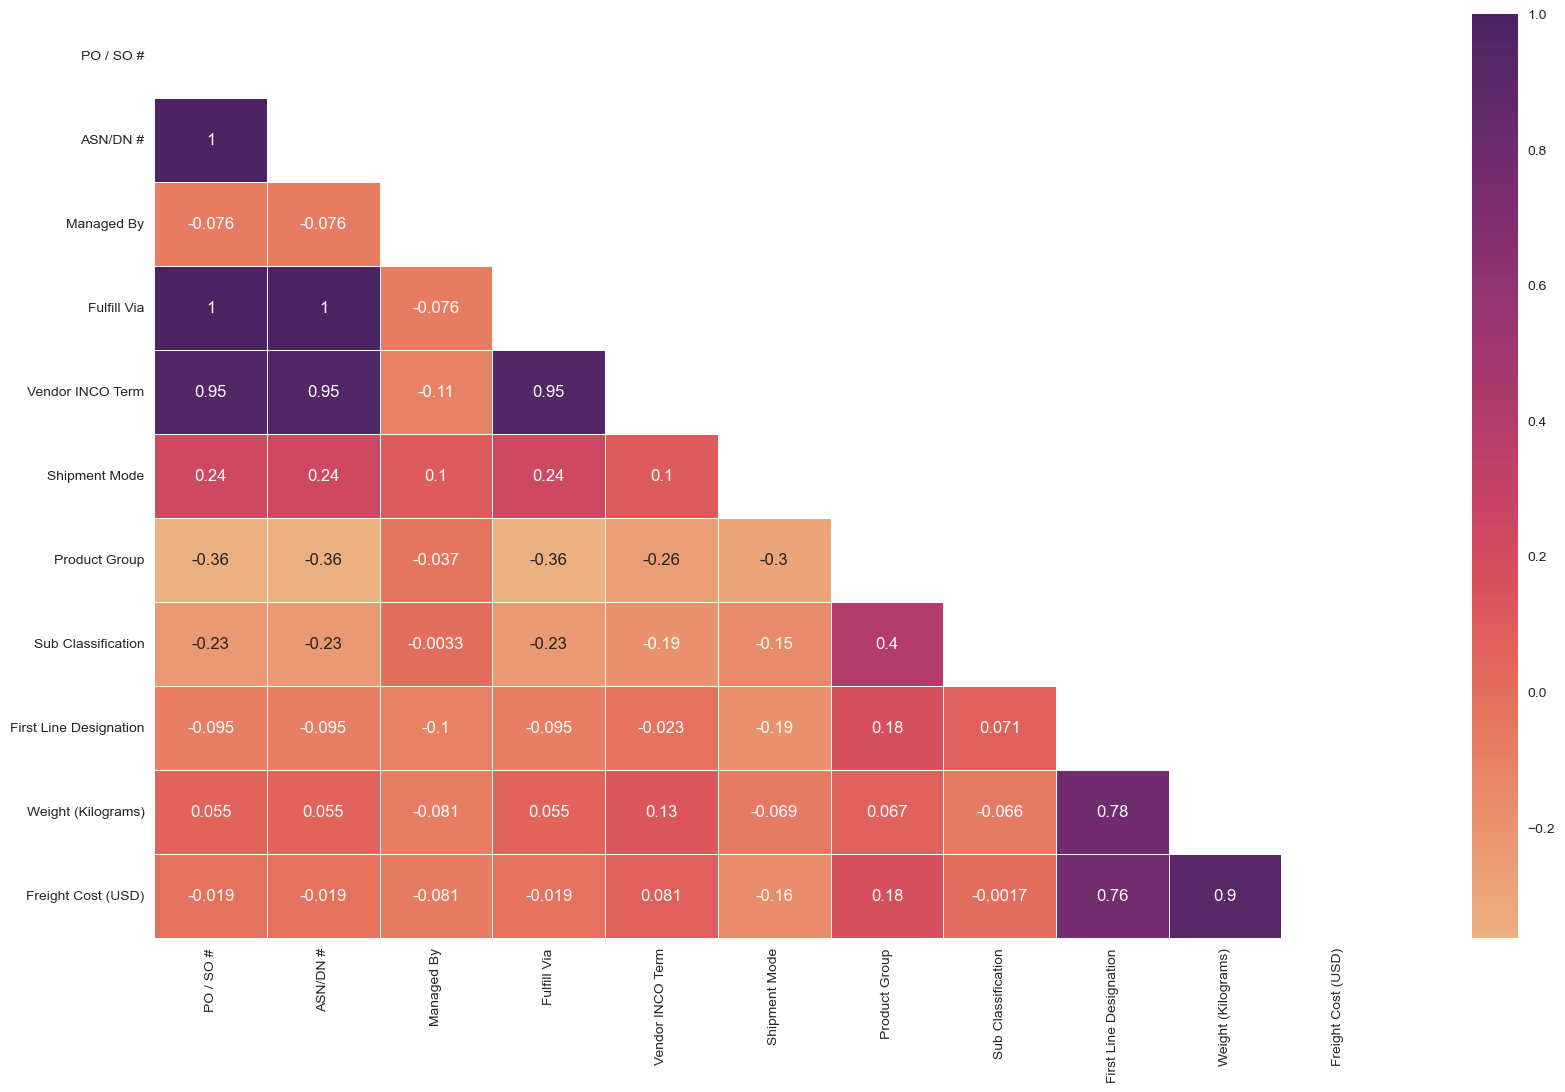

In [82]:
figure(figsize=(20, 12))
mask = np.zeros_like(x.corr('spearman'))
mask[np.triu_indices_from(mask)] = True
sns.heatmap(x.corr('spearman'), annot=True, cmap='flare', linewidths=.5, mask=mask)

import pickle
pickle.dump(pipe, open('scaler.pkl', 'wb'))

In [83]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [84]:
x_test

,PO / SO #,ASN/DN #,Managed By,Fulfill Via,Vendor INCO Term,Shipment Mode,Product Group,Sub Classification,First Line Designation,Weight (Kilograms),Freight Cost (USD)
2222,1,1,2,1,7,0,2,1,0,0.000000,0.000000
7988,1,1,2,1,7,0,2,1,1,0.000598,0.016375
3108,0,0,2,0,3,4,2,1,1,0.000000,0.000000
1807,1,1,2,1,7,4,2,1,1,0.310892,0.075363
6886,1,1,2,1,7,4,2,1,1,0.546529,0.490279
...,...,...,...,...,...,...,...,...,...,...,...
9410,1,1,2,1,7,0,2,1,1,0.524536,0.276795
4714,0,0,3,0,3,4,2,1,0,0.000000,0.000000
3093,0,0,2,0,6,0,2,5,1,0.155895,0.562423
3018,0,0,2,0,5,0,3,3,1,0.000299,0.033789


In [85]:
import statsmodels.api as sm
x_train_sm = sm.add_constant(x_train)
sm_1 = sm.OLS(y_train, x_train_sm).fit()
round(sm_1.pvalues, 2)

const                     0.13
PO / SO #                 0.00
ASN/DN #                  0.00
Managed By                0.23
Fulfill Via               0.00
Vendor INCO Term          0.57
Shipment Mode             0.00
Product Group             0.00
Sub Classification        0.00
First Line Designation    0.00
Weight (Kilograms)        0.00
Freight Cost (USD)        0.00
dtype: float64

In [86]:
sm_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     Line Item Insurance (USD)   R-squared:                       0.302
Model:                                   OLS   Adj. R-squared:                  0.301
Method:                        Least Squares   F-statistic:                     338.2
Date:                       Wed, 28 Dec 2022   Prob (F-statistic):               0.00
Time:                               20:47:18   Log-Likelihood:                -52783.
No. Observations:                       7058   AIC:                         1.056e+05
Df Residuals:                           7048   BIC:                         1.057e+05
Df Model:                                  9                                         
Covariance Type:                   nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    219.1357    143.651      1.525      0.127     -62.463     500.735
PO / SO #                 21.5432      7.469      2.884      0.004       6.902      36.184
ASN/DN #                  21.5432      7.469      2.884      0.004       6.902      36.184
Managed By               -81.3997     67.254     -1.210      0.226    -213.237      50.438
Fulfill Via               21.5432      7.469      2.884      0.004       6.902      36.184
Vendor INCO Term          -3.6502      6.430     -0.568      0.570     -16.255       8.954
Shipment Mode             15.0184      3.269      4.594      0.000       8.610      21.427
Product Group             67.5798     15.387      4.392      0.000      37.417      97.743
Sub Classification       -41.9677      3.364    -12.475      0.000     -48.562     -35.373
First Line Designation  -135.9678     13.103    -10.377      0.000    -161.654    -110.282
Weight (Kilograms)       813.2327     24.446     33.266      0.000     765.311     861.155
Freight Cost (USD)       106.8794     27.399      3.901      0.000      53.168     160.590
==============================================================================
Omnibus:                     7352.972   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           663641.517
Skew:                           5.099   Prob(JB):                         0.00
Kurtosis:                      49.397   Cond. No.                     1.44e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.74e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [87]:
models = {
    'Linear_Regression': LinearRegression(),
    'Lasso': Lasso(),
    'Ridge': Ridge(), 
    'ElasticNet': ElasticNet(),
    'Random_Forest': RandomForestRegressor(n_estimators=300, max_features=8),
    'Ada_boost': AdaBoostRegressor(),
    #'Bagging_regressor': BaggingRegressor(),
    'Gradient_Boost': GradientBoostingRegressor(),
    'Decison_tree': DecisionTreeRegressor(), 
    'Extre_tree': ExtraTreeRegressor(),
    #'KNN_neighboure': KNeighborsRegressor(),
    #'MLP_Regressor': MLPRegressor()
    
}

def importnace of features

In [88]:
def train_model(model, model_name, x=x_train, y=y_train, x_test = x_test, y_test = y_test):
    print("------------------------------", model_name , "------------------------------------------")
    model = model.fit(x, y)
    #scores = cross_val_score(model, x, y, cv=10, scoring='neg_mean_squared_error')
    #rmse_scores = np.sqrt(-scores)
    #print("Score_1: ", rmse_scores)
    y_pred = model.predict(x_test)
    residuals = y_test - y_pred
    r2_score_train = r2_score(model.predict(x_train), y_train)
    r2_score_test = r2_score(y_pred, y_test)
    print("train")
    print("Score", ":", mean_squared_error(y_pred, y_test))
    print("Mean score", ":", np.sqrt(mean_squared_error(y_pred, y_test)))
    #print('Standard deviation: {}'.format(rmse_scores.std()))
    data = pd.DataFrame({"Y_test": y_test , "Y_pred" : y_pred})
    data.head(10)
    viz = FeatureImportances(model)
    viz.fit(x_train, y_train)
    viz.show()
    sns.displot(residuals, kind="kde")
    plt.show()

In [89]:
y

0          47.04
1          47.04
2          47.04
3          47.04
4          47.04
          ...   
10319     705.79
10320     161.71
10321    5284.04
10322     134.03
10323      85.82
Name: Line Item Insurance (USD), Length: 10084, dtype: float64

<AxesSubplot:>

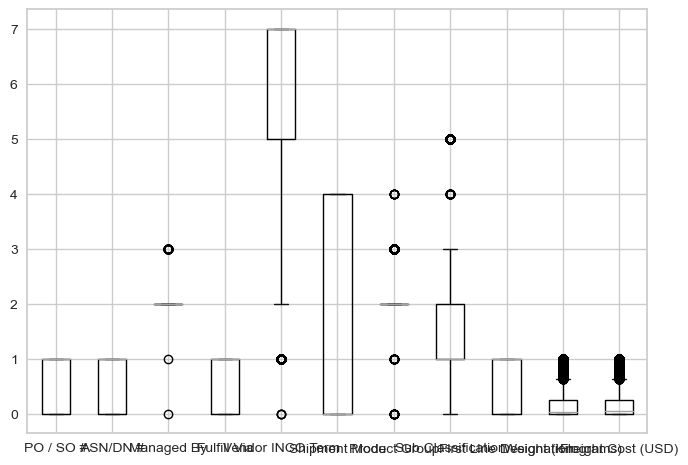

In [90]:
x.boxplot()

------------------------------ Linear_Regression ------------------------------------------
train
Score : 145362.47328776246
Mean score : 381.2643089613326


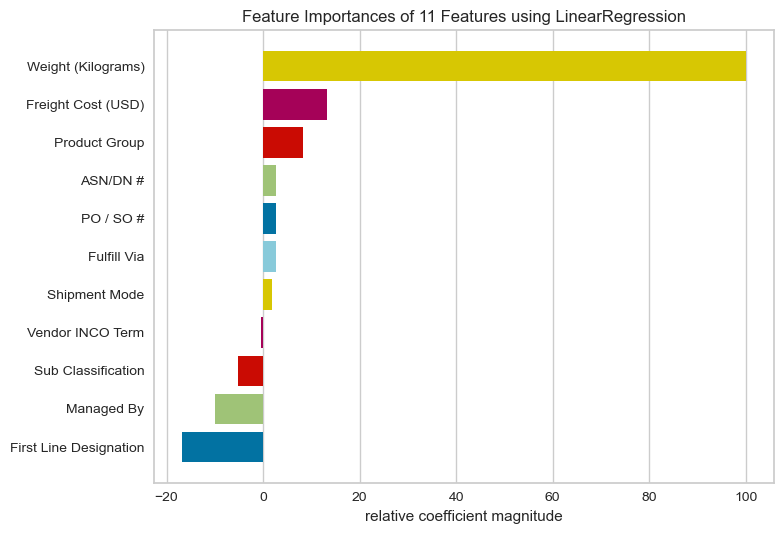

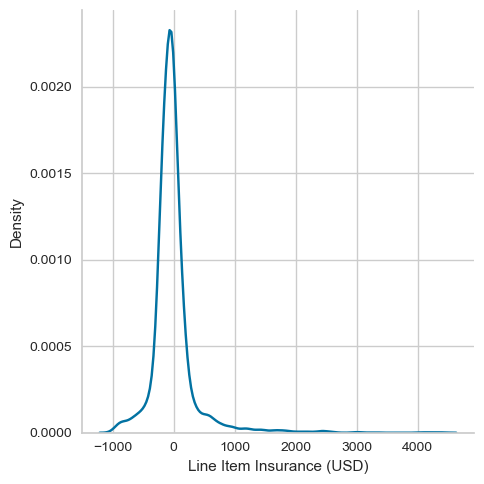

------------------------------ Lasso ------------------------------------------
train
Score : 145568.20670828404
Mean score : 381.5340177602569


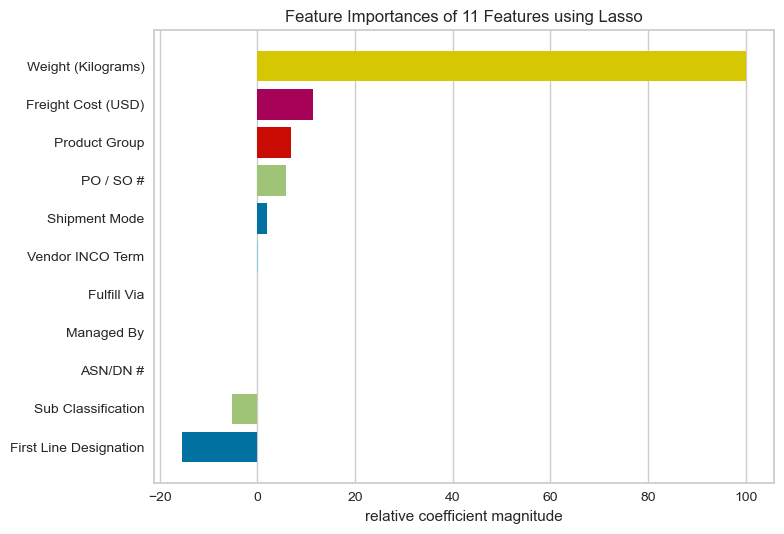

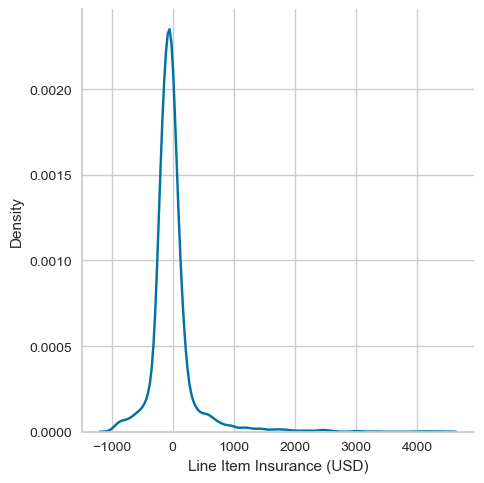

------------------------------ Ridge ------------------------------------------
train
Score : 145368.01557078783
Mean score : 381.2715771871644


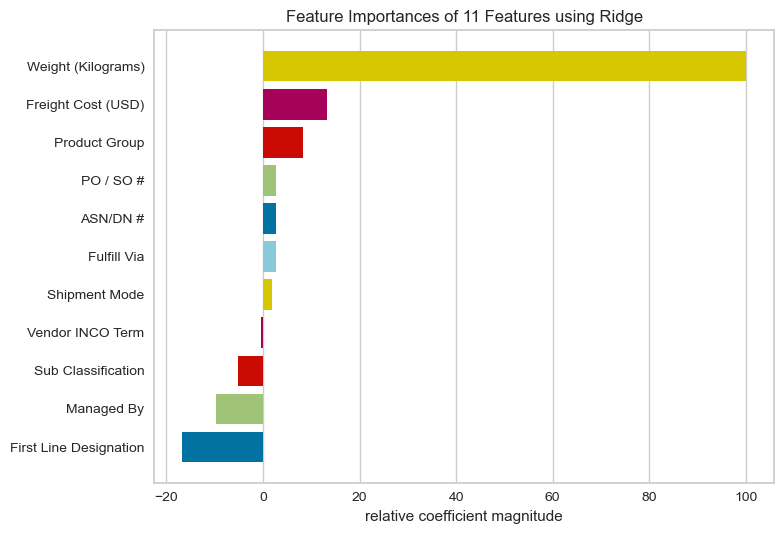

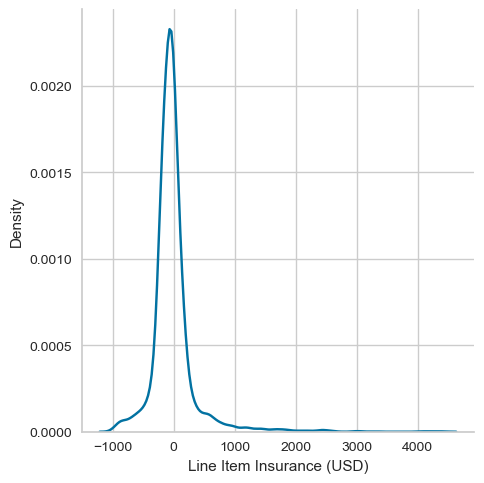

------------------------------ ElasticNet ------------------------------------------
train
Score : 182619.42636141923
Mean score : 427.3399423894509


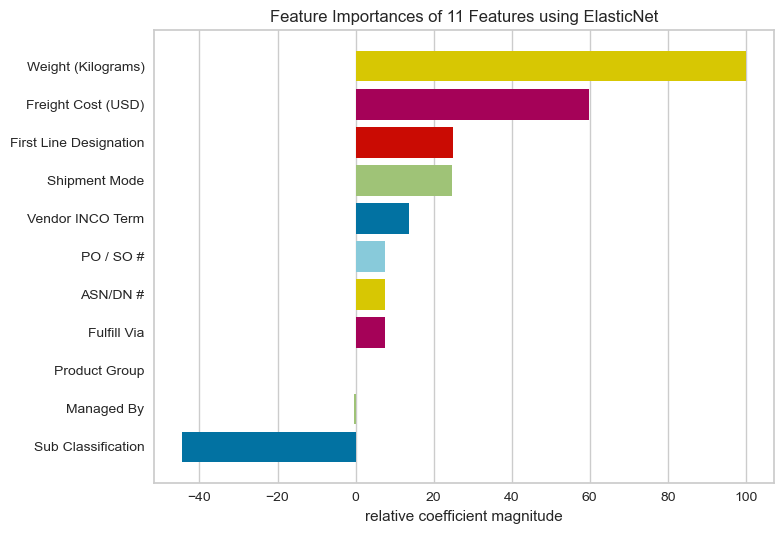

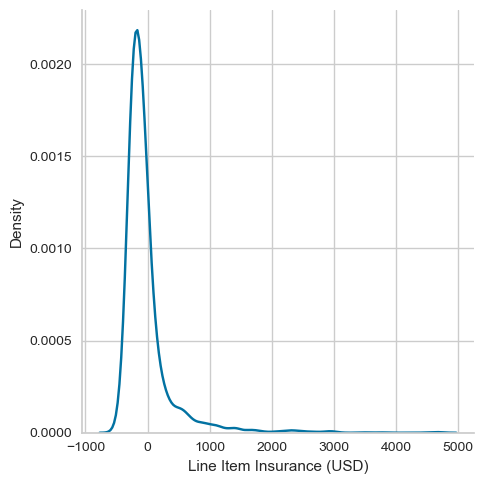

------------------------------ Random_Forest ------------------------------------------
train
Score : 149684.60608819826
Mean score : 386.8909485736236


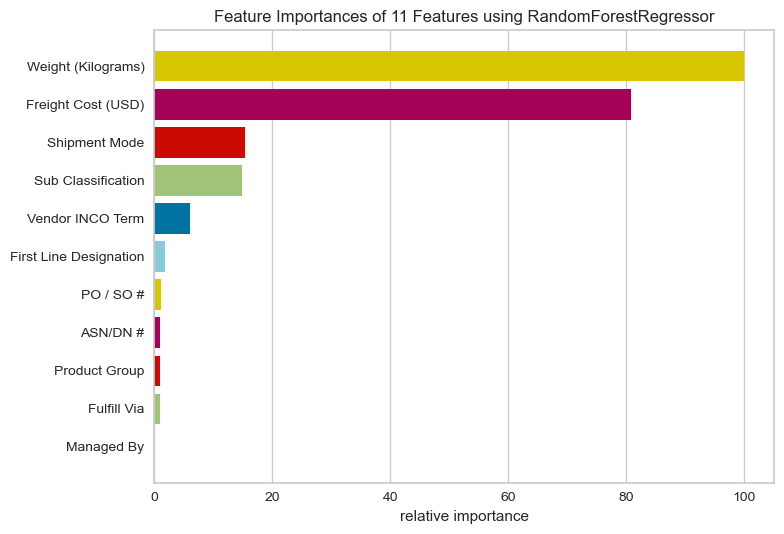

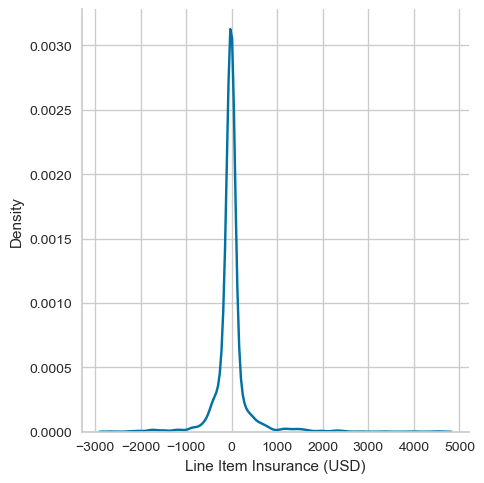

------------------------------ Ada_boost ------------------------------------------
train
Score : 318641.2424345199
Mean score : 564.4831639956324


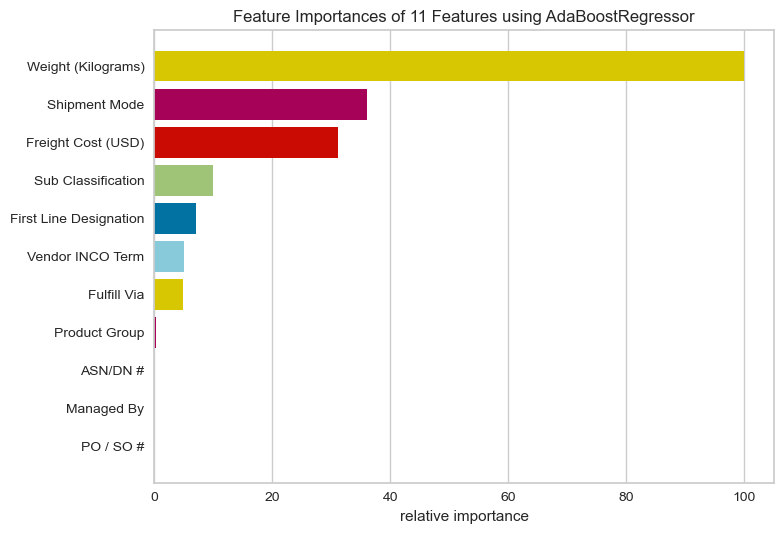

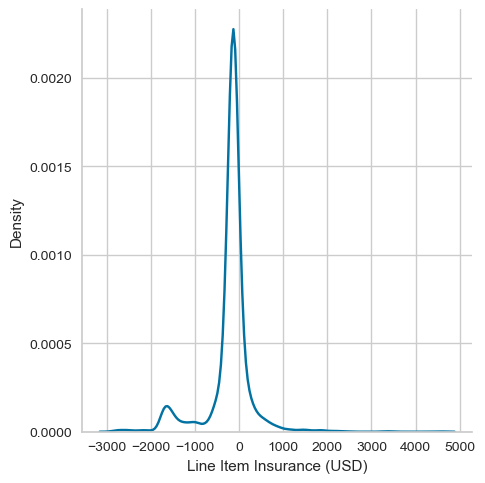

------------------------------ Gradient_Boost ------------------------------------------
train
Score : 129843.09279970272
Mean score : 360.3374707128065


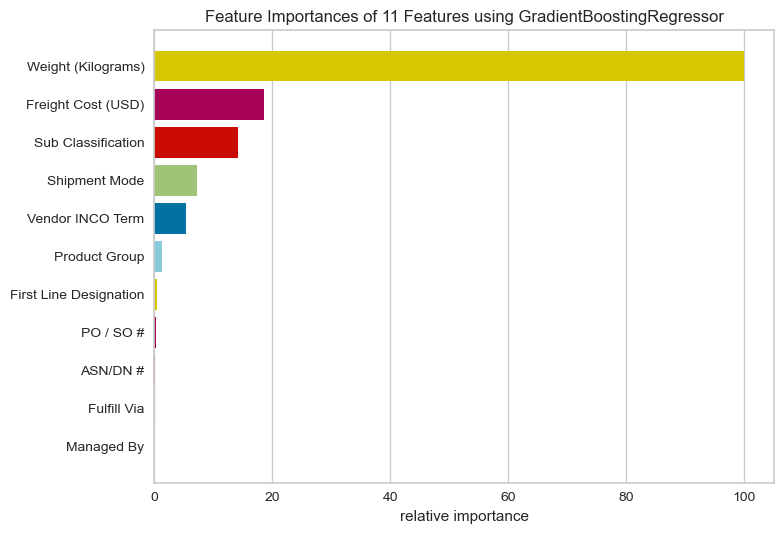

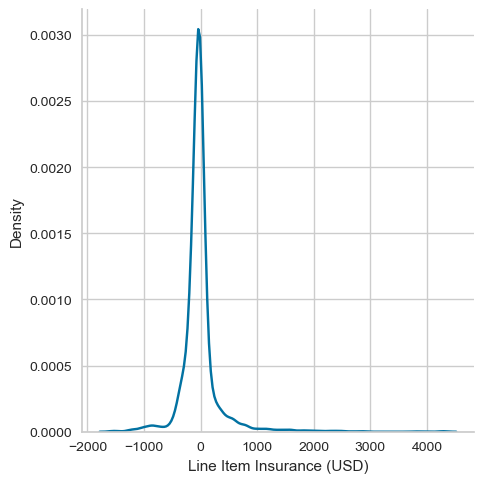

------------------------------ Decison_tree ------------------------------------------
train
Score : 188142.71716720544
Mean score : 433.75421285240037


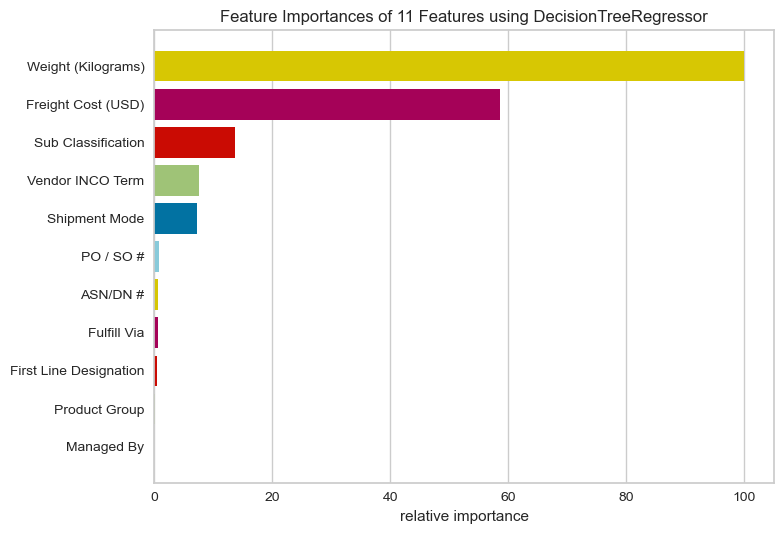

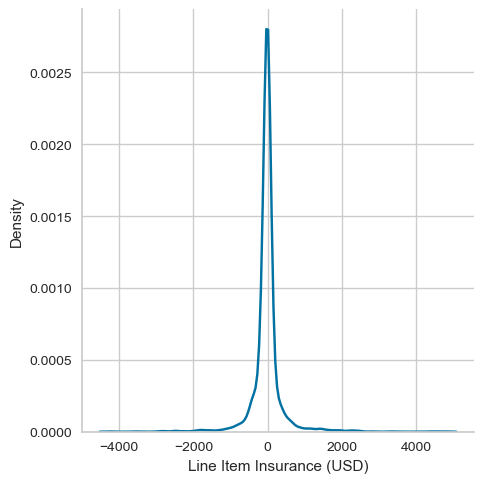

------------------------------ Extre_tree ------------------------------------------
train
Score : 183101.1114072104
Mean score : 427.9031565754224


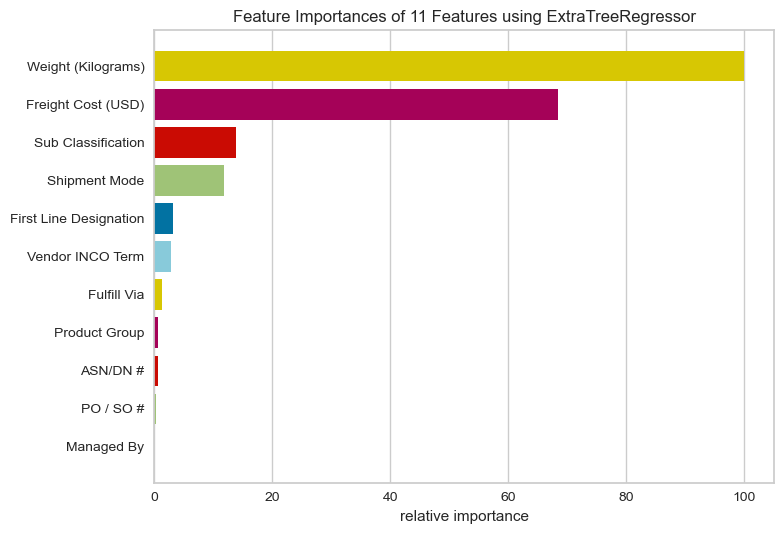

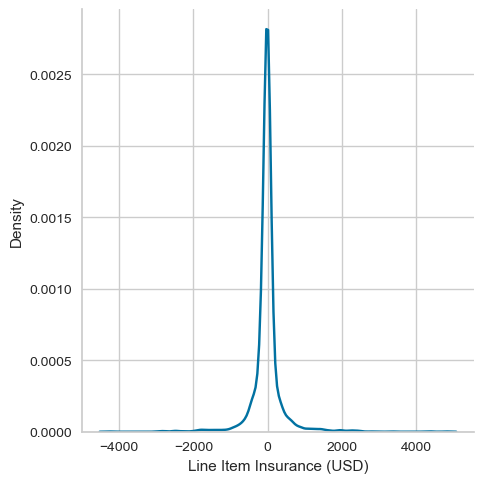

In [91]:
for model_name, model in models.items():
    train_model(model, model_name)

In [92]:
df.columns

Index(['PO / SO #', 'ASN/DN #', 'Managed By', 'Fulfill Via',
       'Vendor INCO Term', 'Shipment Mode', 'Product Group',
       'Sub Classification', 'First Line Designation', 'Weight (Kilograms)',
       'Freight Cost (USD)', 'Line Item Insurance (USD)'],
      dtype='object')

### `Random Forest`

In [ ]:
data_clf_random_forest = []
for i in np.linspace(start=50, stop=500, num=10):
    clf_random_forest = RandomForestRegressor(n_estimators=int(i), random_state=0, oob_score=True)
    clf_random_forest.fit(x_train , y_train)
    data_clf_random_forest.append([i, np.array(clf_random_forest.oob_score_)])
    
data_clf_random_forest_dataframe = pd.DataFrame(data_clf_random_forest, columns=["Trees", 'r2_score'])
data_clf_random_forest

In [302]:
data_max_feature_clf_random_forest = []
for i in range(1, 8):
    clf_random_forest_max_features = RandomForestRegressor(n_estimators=300, max_features=int(i), random_state=0, oob_score=True)
    clf_random_forest_max_features.fit(x_train, y_train)
    data_max_feature_clf_random_forest.append([i, np.array(clf_random_forest_max_features.oob_score_)])

data_max_feature_clf_random_forest_dataframe = pd.DataFrame(data_max_feature_clf_random_forest, columns=["Trees", 'Accurac'])
data_max_feature_clf_random_forest_dataframe

ERROR! Session/line number was not unique in database. History logging moved to new session 374



KeyboardInterrupt



## `Top 3 Models`
* Gradient Boost = RMSE:375.469
* Random Forest = RMSE:386.284
* Decision Tree = RMSE:422.403

## `Random Forest Regression`

In [ ]:
parameters = [
    {'bootstrap': [True, False],
    'max_depth': [80, 90, 100],
    'max_features': ['sqrt'],
    'min_samples_leaf': [3,4],
    'min_samples_split': [5, 10],
    'n_estimators': [800, 1000]}
]

In [ ]:
clf_random_forest_grid = GridSearchCV(estimator = RandomForestRegressor(random_state=0), param_grid = parameters, 
                                cv = 5,  verbose=2, scoring='accuracy',n_jobs = -1)

In [ ]:
clf_random_forest_grid.fit(x_train, y_train)

In [ ]:
clf_random_forest_grid.best_params_

In [93]:
x_train

,PO / SO #,ASN/DN #,Managed By,Fulfill Via,Vendor INCO Term,Shipment Mode,Product Group,Sub Classification,First Line Designation,Weight (Kilograms),Freight Cost (USD)
4427,0,0,2,0,3,4,2,1,0,0.000000,0.000000
4285,0,0,2,0,5,0,3,2,1,0.273040,0.483792
2725,0,0,2,0,6,0,2,1,1,0.003142,0.018326
9237,1,1,2,1,7,4,2,1,0,0.000000,0.000000
1319,1,1,2,1,7,3,2,1,1,0.696738,0.073752
...,...,...,...,...,...,...,...,...,...,...,...
5905,0,0,2,0,3,4,2,5,0,0.000000,0.000000
5349,0,0,2,0,5,2,2,1,0,0.000000,0.000000
5554,0,0,2,0,5,0,3,2,1,0.152902,0.748100
891,0,0,2,0,5,0,2,1,1,0.284111,0.163567


In [94]:
random_forest = RandomForestRegressor(bootstrap=True, max_depth=80, max_features='sqrt', min_samples_leaf=3, min_samples_split=5, n_estimators=800, random_state=42)

In [95]:
random_forest.fit(x_train, y_train)

RandomForestRegressor(max_depth=80, max_features='sqrt', min_samples_leaf=3,
                      min_samples_split=5, n_estimators=800, random_state=42)

In [96]:
y_pred = random_forest.predict(x_test)
residuals = y_test - y_pred
r2_score_train = r2_score(random_forest.predict(x_train), y_train)
r2_score_test = r2_score(y_pred, y_test)
print("MSE", ":", mean_squared_error(y_pred, y_test))
print("RMSE", ":", np.sqrt(mean_squared_error(y_pred, y_test)))

MSE : 129915.36124881131
RMSE : 360.4377356060424


In [424]:
parameters = [
    {
    'max_depth': [2,5,10],
    'min_samples_split': [2, 0.5],
    'min_samples_leaf': [1, 0.5],
    'criterion': ['squared_error', 'absolute_error'],
    'max_features': [None, 'sqrt',  'log2', 0.3, 0.5]
    }
]

In [425]:
clf_decision_tree_grid = GridSearchCV(estimator=DecisionTreeRegressor(random_state=0), param_grid = parameters, 
                                cv = 8,  verbose=2,n_jobs = -1)

In [426]:
clf_decision_tree_grid.fit(x_train, y_train)

Fitting 8 folds for each of 120 candidates, totalling 960 fits


GridSearchCV(cv=8, estimator=DecisionTreeRegressor(random_state=0), n_jobs=-1,
             param_grid=[{'criterion': ['squared_error', 'absolute_error'],
                          'max_depth': [2, 5, 10],
                          'max_features': [None, 'sqrt', 'log2', 0.3, 0.5],
                          'min_samples_leaf': [1, 0.5],
                          'min_samples_split': [2, 0.5]}],
             verbose=2)

In [427]:
clf_decision_tree_grid.best_params_

{'criterion': 'squared_error',
 'max_depth': 5,
 'max_features': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [428]:
decision_tree = DecisionTreeRegressor(criterion='squared_error', max_depth=5, min_samples_leaf=1, min_samples_split=2)

In [429]:
decision_tree.fit(x_train, y_train)

DecisionTreeRegressor(max_depth=5)

In [430]:
y_pred = decision_tree.predict(x_test)
residuals = y_test - y_pred
r2_score_train = r2_score(decision_tree.predict(x_train), y_train)
r2_score_test = r2_score(y_pred, y_test)
print("MSE", ":", mean_squared_error(y_pred, y_test))
print("RMSE", ":", np.sqrt(mean_squared_error(y_pred, y_test)))

MSE : 139362.90272470415
RMSE : 373.31341085568323


In [431]:
x_train

,PO / SO #,ASN/DN #,Managed By,Fulfill Via,Vendor INCO Term,Shipment Mode,Product Group,Sub Classification,First Line Designation,Weight (Kilograms),Freight Cost (USD)
4427,0,0,2,0,3,4,2,1,0,0.000000,0.000000
4285,0,0,2,0,5,0,3,2,1,0.273040,0.483792
2725,0,0,2,0,6,0,2,1,1,0.003142,0.018326
9237,1,1,2,1,7,4,2,1,0,0.000000,0.000000
1319,1,1,2,1,7,3,2,1,1,0.696738,0.073752
...,...,...,...,...,...,...,...,...,...,...,...
5905,0,0,2,0,3,4,2,5,0,0.000000,0.000000
5349,0,0,2,0,5,2,2,1,0,0.000000,0.000000
5554,0,0,2,0,5,0,3,2,1,0.152902,0.748100
891,0,0,2,0,5,0,2,1,1,0.284111,0.163567


In [97]:
import pickle
pickle.dump(random_forest, open('./models/model.pkl', 'wb'))

In [138]:
df[4567:4568]

,PO / SO #,ASN/DN #,Country,Managed By,Fulfill Via,Vendor INCO Term,Shipment Mode,Product Group,Sub Classification,First Line Designation,Weight (Kilograms),Freight Cost (USD),Line Item Insurance (USD),Delay
4706,SCMS,ASN,Vietnam,PMO - US,Direct Drop,EXW,Air,ARV,Adult,Yes,5092.0,7312.6,396.53,0


In [434]:
y[4567:4568]

4706    396.53
Name: Line Item Insurance (USD), dtype: float64

In [442]:
data = [[0, 0, 2, 0, 5, 0, 2, 1, 1, 0.761819, 0.229602]]
prediction = random_forest.predict(data)[0]

In [443]:
prediction

406.2347614179042